# Forecasting Consensus Expectations: Nonfarm Payrolls (NFP)

## Point and Directional Forecasts

**Imports**

In [1]:
import os
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

from tqdm.auto import tqdm
from scipy import stats, special
from scipy.optimize import brentq
from collections import defaultdict
from itertools import product
from scipy.stats import t as student_t, norm, binomtest, jarque_bera
from arch.univariate import ConstantMean, GARCH, StudentsT
from arch.univariate.base import ConvergenceWarning
from IPython.display import display, Markdown

In [2]:
OUT_DIR = "../out"         
DF_FILE       = "nfp_df.parquet"
DF_FULL_FILE  = "nfp_df_full.parquet"

df       = pd.read_parquet(os.path.join(OUT_DIR, DF_FILE),      engine="pyarrow")
df_full  = pd.read_parquet(os.path.join(OUT_DIR, DF_FULL_FILE), engine="pyarrow")

print("df shape     :", df.shape)
print("df_full shape:", df_full.shape)

df shape     : (72662, 10)
df_full shape: (84110, 10)


## 3.0: Baseline static forecast on full sample

Rolling 6-month fixed window. For every valid economist (for a prediction at time t, has a contiguous 6-month forecast history for previous 6 releases), weight prediction by inverse MSE. 


This implements an out-of-sample error estimate with a rolling 6-month estimation window. Weights don't use information from the target month and actual value at month *t* is unseen. In other words, all errors are "live" errors that could have been observed in real time.

Briefly, the procedure: 
1. Starts at 7th release (for 6 month release prior)
2. From estimation window, keep economists that supplied a forecast for all six months (per contiguity rule)
3. Compute MSE for each economist using errors against already known actuals (no lookahead)
4. Generate forecast for release t 
5. Store OOS evaluation error
6. Roll window forward a month and repeat

RMSE – smart : 665.43 k jobs
RMSE – median: 673.57 k jobs
DM statistic :  -0.91
p-value      : 0.3603


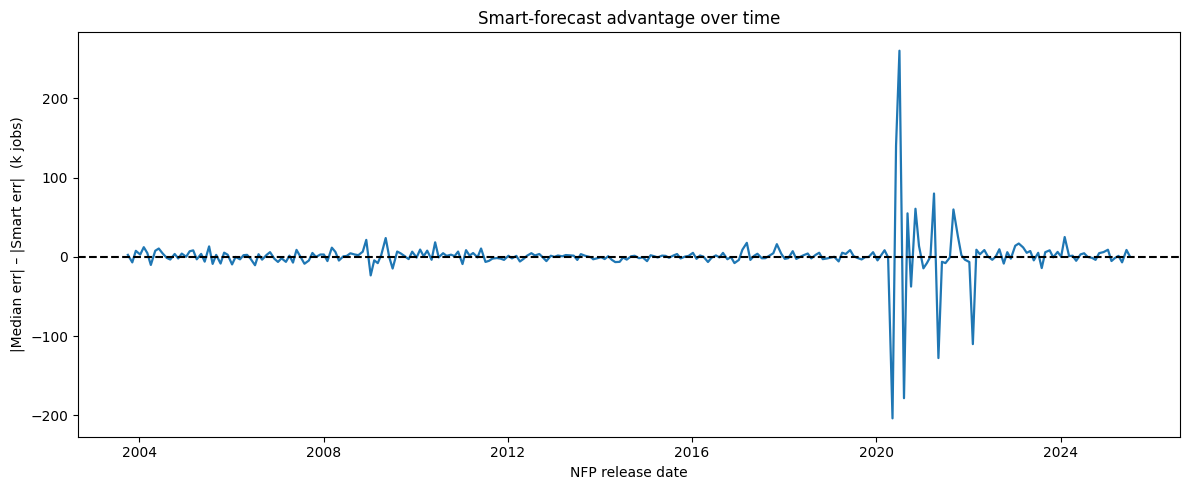


Latest unreleased forecast rows (actual is NaN):


,date,smart,median,actual


In [3]:
# ------------------------------------------------------------
# 1. Build smart & median forecasts for every release
#    (evaluation window = previous 6 releases)
# ------------------------------------------------------------
dates    = np.sort(df_full["release_date"].unique())
records  = []                         # collect all forecasts (even unreleased)

for idx in range(6, len(dates)):
    t_date  = dates[idx]              # target month
    window  = dates[idx-6:idx]        # six-month look-back

    # historical panel for weight estimation
    hist = df_full[df_full["release_date"].isin(window)]

    # economists with forecasts in every month of the window
    contig = hist.groupby("economist")["forecast"].apply(lambda s: s.notna().all())
    econs  = contig[contig].index
    if econs.empty:
        continue

    # inverse-MSE weights
    mse = (hist[hist["economist"].isin(econs)]
           .groupby("economist")["error"]
           .apply(lambda s: np.nanmean(np.square(s))))
    ridge   = 1e-6
    weights = 1.0 / (mse + ridge)
    weights /= weights.sum()

    # current-month forecasts, align & renormalise
    cur     = df_full[(df_full["release_date"] == t_date) &
                      (df_full["economist"].isin(econs))]
    f_t     = cur.set_index("economist")["forecast"].dropna()
    weights = weights.reindex(f_t.index).dropna()
    if weights.empty:
        continue
    weights /= weights.sum()

    # point forecasts
    smart   = np.dot(weights, f_t.loc[weights.index])
    median  = df_full.loc[df_full["release_date"] == t_date,
                          "forecast"].dropna().median()
    actual  = df_full.loc[df_full["release_date"] == t_date,
                          "actual"].iloc[0]          # may be NaN (e.g. July-25)

    records.append((t_date, smart, median, actual))

# ------------------------------------------------------------------
# 2. Split into “all” vs “evaluation” sets
# ------------------------------------------------------------------
oos_all  = pd.DataFrame(records,
                        columns=["date", "smart", "median", "actual"])
oos_eval = oos_all.dropna(subset=["actual"]).copy()     # evaluation sample

# ------------------------------------------------------------------
# 3. Evaluation metrics (only rows with realised actuals)
# ------------------------------------------------------------------
oos_eval["smart_err"]  = oos_eval["smart"]  - oos_eval["actual"]
oos_eval["median_err"] = oos_eval["median"] - oos_eval["actual"]

rmse_smart  = np.sqrt((oos_eval["smart_err"]**2).mean())
rmse_median = np.sqrt((oos_eval["median_err"]**2).mean())
print(f"RMSE – smart : {rmse_smart:6.2f} k jobs")
print(f"RMSE – median: {rmse_median:6.2f} k jobs")

# Diebold-Mariano test on squared-error loss
d        = oos_eval["smart_err"]**2 - oos_eval["median_err"]**2
dm_stat  = d.mean() / d.std(ddof=1) * np.sqrt(len(d))
dm_p     = 2 * (1 - stats.norm.cdf(abs(dm_stat)))
print(f"DM statistic : {dm_stat:6.2f}")
print(f"p-value      : {dm_p:.4f}")

# ------------------------------------------------------------------
# 4. Visualise improvement timeline (evaluation sample)
# ------------------------------------------------------------------
oos_eval["improvement"] = (oos_eval["median_err"].abs() -
                           oos_eval["smart_err"].abs())

plt.figure(figsize=(12, 5))
plt.plot(oos_eval["date"], oos_eval["improvement"],
         lw=1.6, color="tab:blue")
plt.axhline(0, ls="--", c="k")
plt.title("Smart-forecast advantage over time")
plt.xlabel("NFP release date")
plt.ylabel("|Median err| – |Smart err|  (k jobs)")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# 5. (Optional) Inspect the unreleased month’s forecasts
# ------------------------------------------------------------------
print("\nLatest unreleased forecast rows (actual is NaN):")
display(oos_all[oos_all["actual"].isna()])


Noticeably erratic performance in COVID and subsequent aftermath (~2020-2022). Pertinent to subset out as 2020-2022 is unlikely to be generalizable to future performance.

## 3.1: Static Forecast, inverse-MSE weighted

Here, in addition to the level forecast, we also introduce a directional forecast. Briefly: 


**Directional–forecast procedure (Beat / Miss classification)**  
1. For each release, keep valid economists within contiguity filter 
2. For every valid economist, compute trailing 6-month MSE, convert to weights (inverse MSE), build smart point forecast via normalized inverse-MSE weighting
3. Label the realized print (true y) as beat == 1 if y_t > median_t, miss == 1 otherwise. Same labeling procedure for smart forecast. 
4. Compute hit-rate: Fraction of releases where predicted sign matches realized sign. Test significance with a binomial/PT test. 
5. Do this for contiguity windows of 3, 6, 12, and 24 months

- We evaluate every static-ensemble variant on both the full panel (df_full) and COVID-filtered panel (df)
- Apply the robust-winner rule on the COVID-filtered panel (winner is method that has lowest RMSE_smart that satisfies DM_p < 0.10, Binom_p < 0.10, PT_p < 0.10)
- Print historical evaluation tables for both panels, then produce a live forecast (if applicable) for upcoming release

In [4]:
# ─────────────────────────── settings ───────────────────────────
contiguity_windows = [3, 6, 12, 24]
methods            = ["inverse_mse", "inverse_mae", "equal_weight"]
ridge              = 1e-6

# helper ─────────────────────────────────────────────────────────
def run_static_panel(df_panel: pd.DataFrame, name: str):
    dates = np.sort(df_panel["release_date"].unique())
    eval_rows, live_rows = [], []

    for window, method in tqdm(product(contiguity_windows, methods),
                               total=len(contiguity_windows)*len(methods),
                               desc=f"{name} grid"):

        preds = []                     # per-release records
        for idx in range(window, len(dates)):
            t = dates[idx]
            # ----- look-back slice -----
            hist = df_panel[df_panel["release_date"].isin(dates[idx-window:idx])]
            # economists with all forecasts in window
            econs = hist.groupby("economist")["forecast"].apply(lambda s: s.notna().all())
            econs = econs[econs].index
            if econs.empty:  continue

            if method == "equal_weight":
                w = pd.Series(1.0, index=econs)
            else:
                grp = hist[hist["economist"].isin(econs)].groupby("economist")["error"]
                score = grp.apply(lambda s: np.nanmean(s**2) if method=="inverse_mse"
                                  else np.nanmean(np.abs(s)))
                w = 1.0/(score+ridge)
            w /= w.sum()

            # ----- current forecasts -----
            cur = df_panel[(df_panel["release_date"]==t) & (df_panel["economist"].isin(w.index))]
            f_t = cur.set_index("economist")["forecast"].dropna()
            w   = w.reindex(f_t.index).dropna()
            if w.empty:  continue
            w /= w.sum()

            smart  = np.dot(w, f_t.loc[w.index])
            median = df_panel.loc[df_panel["release_date"]==t, "forecast"].dropna().median()
            actual = df_panel.loc[df_panel["release_date"]==t, "actual"].iloc[0]
            preds.append((t, smart, median, actual))

        # nothing for this (window,method)?
        if not preds:  continue

        oos = pd.DataFrame(preds, columns=["date","smart","median","actual"])

        # save unreleased forecast (if latest actual is NaN)
        unreleased = oos[oos["actual"].isna()]
        if not unreleased.empty:
            last = unreleased.iloc[-1]
            live_rows.append({"panel" : name,
                              "window": window,
                              "method": method,
                              "date"  : last["date"],
                              "smart" : last["smart"],
                              "median": last["median"],
                              "pred_dir": int(last["smart"] > last["median"]) })

        # evaluation on realised months only
        eval_df = oos.dropna(subset=["actual"]).copy()
        if eval_df.empty:  continue

        eval_df["smart_err"]  = eval_df["smart"]  - eval_df["actual"]
        eval_df["median_err"] = eval_df["median"] - eval_df["actual"]
        eval_df["actual_dir"] = (eval_df["actual"] > eval_df["median"]).astype(int)
        eval_df["pred_dir"]   = (eval_df["smart"]  > eval_df["median"]).astype(int)

        obs         = len(eval_df)
        rmse_smart  = np.sqrt((eval_df["smart_err"]**2 ).mean())
        rmse_median = np.sqrt((eval_df["median_err"]**2).mean())

        d       = eval_df["smart_err"]**2 - eval_df["median_err"]**2
        dm_stat = d.mean()/d.std(ddof=1)*np.sqrt(obs)
        dm_p    = 2*(1-stats.norm.cdf(abs(dm_stat)))

        hits     = (eval_df["actual_dir"] == eval_df["pred_dir"]).astype(int)
        hit_rate = hits.mean()
        binom_p  = stats.binomtest(hits.sum(), obs, 0.5).pvalue
        p1,p2    = eval_df["pred_dir"].mean(), eval_df["actual_dir"].mean()
        c_joint  = (eval_df["pred_dir"] & eval_df["actual_dir"]).mean()
        pt_stat  = (c_joint-p1*p2)/np.sqrt(p1*p2*(1-p1)*(1-p2)/obs)
        pt_p     = 2*(1-stats.norm.cdf(abs(pt_stat)))

        eval_rows.append({"panel":name,"window":window,"method":method,
                          "obs":obs,"RMSE_smart":rmse_smart,"RMSE_median":rmse_median,
                          "HitRate":hit_rate,"Binom_p":binom_p,"PT_p":pt_p,"DM_p":dm_p})
    return pd.DataFrame(eval_rows), pd.DataFrame(live_rows)

# ─────────────────────────── run panels ─────────────────────────
res_covid, live_covid = run_static_panel(df,       "COVID")
res_full , live_full  = run_static_panel(df_full,  "Full")

# ───────────────── robust-winner pick (COVID panel) ────────────
robust = res_covid[(res_covid["DM_p"]<0.10)&
                   (res_covid["Binom_p"]<0.10)&
                   (res_covid["PT_p"]<0.10)]
winner = (robust if not robust.empty else res_covid).loc[
            lambda d: d["RMSE_smart"].idxmin() ]

win_w  = int(winner["window"]);  win_m = winner["method"]

# fetch its live forecast (COVID list suffices)
live_row = (live_covid[(live_covid["window"]==win_w)&
                       (live_covid["method"]==win_m)]
            if not live_covid.empty else pd.DataFrame())

# ────────────────────────── PRINT SECTION ──────────────────────
pd.set_option("display.float_format", "{:.3f}".format)

print("\n--- COVID-filtered panel (historical) ---")
print(res_covid.sort_values(["window", "method"]).to_string(index=False))

print("\n--- Full panel (historical) ---")
print(res_full.sort_values(["window", "method"]).to_string(index=False))

# ----- live forecasts for COVID panel, all windows -------------
if live_covid.empty:
    print("\nNo unreleased month – all actuals available.")
else:
    # pick the best-method (win_m) but show *every* window’s live row
    live_rows_method = (live_covid[live_covid["method"] == win_m]
                        .sort_values(["window"]))

    if live_rows_method.empty:
        print(f"\nNo unreleased month for method={win_m}.")
    else:
        print(f"\n--- LIVE FORECASTS  •  method = {win_m} ---")
        for _, row in live_rows_method.iterrows():
            direction = "Beat" if row["pred_dir"] else "Miss"
            w  = int(row["window"])
            dt = pd.to_datetime(row["date"]).date()
            print(f"[{w:2d}-mo]  Date: {dt}  |  "
                  f"Smart: {row['smart']:.1f} k  |  "
                  f"Median: {row['median']:.1f} k  |  "
                  f"Signal: {direction}")


COVID grid:   0%|          | 0/12 [00:00<?, ?it/s]

Full grid:   0%|          | 0/12 [00:00<?, ?it/s]


--- COVID-filtered panel (historical) ---
panel  window       method  obs  RMSE_smart  RMSE_median  HitRate  Binom_p  PT_p  DM_p
COVID       3 equal_weight  229      72.120       73.123    0.598    0.004 0.003 0.015
COVID       3  inverse_mae  229      72.073       73.123    0.572    0.034 0.028 0.039
COVID       3  inverse_mse  229      72.077       73.123    0.563    0.064 0.049 0.114
COVID       6 equal_weight  226      72.063       73.102    0.611    0.001 0.001 0.025
COVID       6  inverse_mae  226      72.036       73.102    0.575    0.028 0.022 0.027
COVID       6  inverse_mse  226      71.920       73.102    0.575    0.028 0.020 0.033
COVID      12 equal_weight  220      71.496       72.318    0.577    0.026 0.021 0.119
COVID      12  inverse_mae  220      71.436       72.318    0.564    0.068 0.056 0.098
COVID      12  inverse_mse  220      71.342       72.318    0.577    0.026 0.021 0.071
COVID      24 equal_weight  208      68.477       69.321    0.553    0.145 0.129 0.238


Clearly, level edge is eroded over the entire sample due to huge variance during COVID. 
- We need to subset out COVID period forecasts (or account for heavy tails somehow) if we want a good level forecast
- Directional edge can be maintained even through crises periods. Keep 6 or 12 month lookback window.

Inverse MSE weighting with a 12-month contiguity window provides best results 

**Stratified Analysis**

In [5]:
# ---------------------------------------------------------------------------
# STRATIFIED STATIC ENSEMBLE – full panel (df_full)
# Handles missing actuals and produces live forecasts
# ---------------------------------------------------------------------------
windows = [3, 6, 12]        # contiguity windows to test
ridge   = 1e-6

# regime buckets (edit freely)
periods = {
    "2000-2007  (pre-GFC)"       : ("2000-01-01", "2007-12-31"),
    "2008-2009  (GFC crisis)"    : ("2008-01-01", "2009-12-31"),
    "2010-2019  (long expansion)": ("2010-01-01", "2019-12-31"),
    "2020-2022  (COVID + rebound)":("2020-01-01", "2022-12-31"),
    "2023-2025  (post-COVID)"    : ("2023-01-01", "2025-12-31")
}

dates_full = np.sort(df_full["release_date"].unique())
all_summaries = {}
live_preds    = []        # store unreleased-month forecasts

for W in windows:
    records = []

    # -------------------------------------------------------------
    # Walk forward through release dates
    # -------------------------------------------------------------
    for idx in tqdm(range(W, len(dates_full)),
                    desc=f"Static {W}-mo ensemble"):
        t_date      = dates_full[idx]
        window_back = dates_full[idx-W:idx]
        hist        = df_full[df_full["release_date"].isin(window_back)]

        # economists with full coverage in the window
        valid = hist.groupby("economist")["forecast"].apply(lambda s: s.notna().all())
        econs = valid[valid].index
        if econs.empty:
            continue

        # inverse-MSE weights
        mse   = (hist[hist["economist"].isin(econs)]
                 .groupby("economist")["error"]
                 .apply(lambda s: np.nanmean(s**2)))
        w     = 1.0 / (mse + ridge)
        w    /= w.sum()

        # current forecasts & align
        cur   = df_full[(df_full["release_date"] == t_date) &
                        (df_full["economist"].isin(w.index))]
        f_t   = cur.set_index("economist")["forecast"].dropna()
        w     = w.reindex(f_t.index).dropna()
        if w.empty:
            continue
        w    /= w.sum()

        yhat_smart  = np.dot(w, f_t.loc[w.index])
        yhat_median = df_full.loc[df_full["release_date"] == t_date,
                                  "forecast"].dropna().median()
        y_actual    = df_full.loc[df_full["release_date"] == t_date,
                                  "actual"].iloc[0]

        records.append((t_date, yhat_smart, yhat_median, y_actual))

    # ------------------------------------------------------------------
    # OOS DataFrame (keep NaN actual rows for live display)
    # ------------------------------------------------------------------
    cols     = ["date", "smart", "median", "actual"]
    oos_all  = pd.DataFrame(records, columns=cols)
    oos_eval = oos_all.dropna(subset=["actual"]).copy()

    # save live (unreleased) forecast, if any
    unreleased = oos_all[oos_all["actual"].isna()]
    if not unreleased.empty:
        live_preds.append({
            "window": W,
            "date":   unreleased.iloc[-1]["date"],
            "smart":  unreleased.iloc[-1]["smart"],
            "median": unreleased.iloc[-1]["median"]
        })

    # nothing to summarise yet?
    if oos_eval.empty:
        all_summaries[W] = pd.DataFrame()
        continue

    # error / direction columns
    oos_eval["smart_err"]  = oos_eval["smart"]  - oos_eval["actual"]
    oos_eval["median_err"] = oos_eval["median"] - oos_eval["actual"]
    oos_eval["actual_dir"] = (oos_eval["actual"] > oos_eval["median"]).astype(int)
    oos_eval["pred_dir"]   = (oos_eval["smart"]  > oos_eval["median"]).astype(int)

    # ------------------------------------------------------------------
    # Stratified summary table
    # ------------------------------------------------------------------
    summary = []
    for label, (start, end) in tqdm(periods.items(),
                                    desc=f"Stratified ({W}-mo)"):
        sub = oos_eval[(oos_eval["date"] >= start) & (oos_eval["date"] <= end)]
        if sub.empty:
            continue

        # DM statistic on squared errors
        d        = sub["smart_err"]**2 - sub["median_err"]**2
        dm_stat  = d.mean() / d.std(ddof=1) * np.sqrt(len(d))
        dm_p     = 2*(1 - stats.norm.cdf(abs(dm_stat)))

        # directional metrics
        hits     = (sub["actual_dir"] == sub["pred_dir"]).astype(int)
        n        = len(hits)
        hit_rate = hits.mean()
        binom_p  = stats.binomtest(hits.sum(), n, 0.5).pvalue
        p1, p2   = sub["pred_dir"].mean(), sub["actual_dir"].mean()
        c_joint  = (sub["pred_dir"] & sub["actual_dir"]).mean()
        pt_stat  = (c_joint - p1*p2) / np.sqrt(p1*p2*(1-p1)*(1-p2)/n)
        pt_p     = 2*(1 - stats.norm.cdf(abs(pt_stat)))

        summary.append({
            "Period":   label,
            "Obs":      n,
            "HitRate":  hit_rate,
            "Binom_p":  binom_p,
            "PT_stat":  pt_stat,
            "PT_p":     pt_p,
            "DM_stat":  dm_stat,
            "DM_p":     dm_p
        })

    all_summaries[W] = pd.DataFrame(summary)

# ------------------------------------------------------------------
# Display stratified tables
# ------------------------------------------------------------------
for W, df_sum in all_summaries.items():
    print(f"\n=== Stratified Results for {W}-Month Window ===")
    if df_sum.empty:
        print("No realised data yet.")
    else:
        print(df_sum.to_string(index=False, float_format="{:.3f}".format))


Static 3-mo ensemble:   0%|          | 0/265 [00:00<?, ?it/s]

Stratified (3-mo):   0%|          | 0/5 [00:00<?, ?it/s]

Static 6-mo ensemble:   0%|          | 0/262 [00:00<?, ?it/s]

Stratified (6-mo):   0%|          | 0/5 [00:00<?, ?it/s]

Static 12-mo ensemble:   0%|          | 0/256 [00:00<?, ?it/s]

Stratified (12-mo):   0%|          | 0/5 [00:00<?, ?it/s]


=== Stratified Results for 3-Month Window ===
                      Period  Obs  HitRate  Binom_p  PT_stat  PT_p  DM_stat  DM_p
        2000-2007  (pre-GFC)   54    0.593    0.220    1.226 0.220    0.188 0.851
     2008-2009  (GFC crisis)   24    0.625    0.307    1.448 0.148   -1.088 0.276
 2010-2019  (long expansion)  120    0.508    0.927    0.209 0.835   -0.015 0.988
2020-2022  (COVID + rebound)   36    0.611    0.243    0.943 0.346   -1.174 0.240
     2023-2025  (post-COVID)   31    0.677    0.071    0.916 0.360   -1.658 0.097

=== Stratified Results for 6-Month Window ===
                      Period  Obs  HitRate  Binom_p  PT_stat  PT_p  DM_stat  DM_p
        2000-2007  (pre-GFC)   51    0.529    0.780    0.408 0.683    0.356 0.722
     2008-2009  (GFC crisis)   24    0.750    0.023    2.342 0.019   -1.095 0.274
 2010-2019  (long expansion)  120    0.533    0.523    0.777 0.437   -1.470 0.142
2020-2022  (COVID + rebound)   36    0.556    0.618    0.021 0.983   -0.899 0.369
    

1. Ex-COVID, 12-month inverse MSE ensemble beats median in magnitude of accuracy and directional edge. 
2. Crisis behavior (stress tests): level advantage disappears (variance of economist forecast explodes), ensemble has surprising directional edge in 08-09 crisis. Highly significant. 
3. Regime dependence: Skill of our model is clearest in the long, stable 2010-2019 period. Post-COVID shows no significance yet. Weights may need dynamic updating. 

Favor 12-month contiguity window. Future implementations we should augment with a crisis-robust variant (student t-likelihood to account for tails, dynamic weights).

### Robust majority-vote approach to directional edge

**Robust ensemble: inverse MSE + inverse MAE + equal weight (9 method majority vote)**

In [ ]:
# -------------------------------------------------------------
# Robust majority-vote directional back-test
# • Nine smart ensembles: (window ∈ {3,6,12}) × (method ∈ {inv-MSE, inv-MAE, equal})
# • Robust call = majority vote of the nine
# -------------------------------------------------------------
import numpy as np, pandas as pd, warnings, scipy.stats as st
from itertools import product
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")
np.seterr(all="ignore")

# ---------- parameters ---------------------------------------
PANEL       = df_full          # use df_full if you prefer the full sample
WINDOWS     = [3, 6, 12]
METHODS     = ["inverse_mse", "inverse_mae", "equal_weight"]
RIDGE       = 1e-6

# ---------- helper to get weights ---------------------------------
def calc_weights(hist_df: pd.DataFrame, method: str, ridge: float = 1e-6) -> pd.Series:
    """
    hist_df : DataFrame with at least columns ['economist', 'error']
              (already restricted to economists that pass the contiguity rule)
    method  : "equal_weight" | "inverse_mse" | "inverse_mae"
    ridge   : small stabiliser to avoid division-by-zero in inverse weights
    returns : pd.Series indexed by economist with normalised weights that sum to 1
    """
    if method == "equal_weight":
        w = pd.Series(1.0, index=hist_df["economist"].unique())

    else:
        if method == "inverse_mse":
            # mean-squared error per economist
            score = (hist_df.groupby("economist")["error"]
                               .apply(lambda s: np.nanmean(np.square(s))))
        else:                       # "inverse_mae"
            # mean-absolute error per economist
            score = (hist_df.groupby("economist")["error"]
                               .apply(lambda s: np.nanmean(np.abs(s))))

        w = 1.0 / (score + ridge)

    return w / w.sum()


# ---------- main loop ----------------------------------------
dates = np.sort(PANEL["release_date"].unique())
dir_calls = {m: pd.Series(index=dates, dtype="Int64")  # store Beat/Miss per method
             for m in product(WINDOWS, METHODS)}

for win, meth in tqdm(product(WINDOWS, METHODS),
                      total=len(WINDOWS)*len(METHODS),
                      desc="building nine ensembles"):

    for idx in range(win, len(dates)):
        t = dates[idx]
        hist_dates = dates[idx-win:idx]
        hist = PANEL[PANEL["release_date"].isin(hist_dates)]

        # contiguity filter
        elig = (hist.groupby("economist")["forecast"]
                     .apply(lambda s: s.notna().all()))
        econs = elig[elig].index
        if econs.empty:
            continue

        # weights
        w = calc_weights(hist[hist["economist"].isin(econs)], meth)

        # current forecasts
        cur = PANEL[(PANEL["release_date"] == t) &
                    (PANEL["economist"].isin(w.index))]
        f_t = cur.set_index("economist")["forecast"].dropna()
        w   = w.reindex(f_t.index).dropna()
        if w.empty:
            continue
        w /= w.sum()

        smart = np.dot(w, f_t.loc[w.index])
        median = PANEL.loc[PANEL["release_date"] == t,
                           "forecast"].dropna().median()
        dir_calls[(win, meth)].loc[t] = int(smart > median)

# ---------- majority vote & evaluation -----------------------
records = []
for t in dates:
    actual = PANEL.loc[PANEL["release_date"] == t, "actual"].iloc[0]
    median = PANEL.loc[PANEL["release_date"] == t, "forecast"].dropna().median()
    if pd.isna(actual):
        continue                                  # skip unreleased
    actual_dir = int(actual > median)

    votes = [series.get(t, pd.NA) for series in dir_calls.values()]
    votes = [v for v in votes if v is not pd.NA]
    if len(votes) < 9:                            # contiguity gaps
        continue
    robust_dir = int(sum(votes) >= 5)             # majority vote
    records.append(robust_dir == actual_dir)

hits = sum(records)

total = len(records)
print("\nRobust majority-vote back-test")
print(f"  Releases evaluated : {total}")
print(f"  Hits (direction)   : {hits}")
print(f"  Hit rate           : {hits/total:.3f}")


building nine ensembles:   0%|          | 0/9 [00:00<?, ?it/s]


Robust majority-vote back-test
  Releases evaluated : 256
  Hits (direction)   : 149
  Hit rate           : 0.582


**Robust ensemble: inverse MSE + inverse MAE + soft-BMA (9 method majority vote)**

In [45]:
import numpy as np, pandas as pd, warnings
from itertools import product
from tqdm.auto import tqdm
from scipy.stats import t as student_t, binomtest

warnings.filterwarnings("ignore")
np.seterr(all="ignore")

# ---------------- CONFIG -------------------------------------------------
WINDOWS  = [3, 6, 12]                       # contiguity windows (months)
METHODS  = ["inverse_mse", "inverse_mae", "soft_bma"]
RIDGE    = 1e-6
NU_SOFT  = 5                                # ν for Student-t soft-BMA
PANEL    = df_full                              # COVID-filtered panel

# ---------------- helper: weighting rules --------------------------------
def calc_weights(hist_df: pd.DataFrame, method: str) -> pd.Series:
    """Return normalised weights (index = economist) for the chosen method."""
    if method == "inverse_mse":
        score = (hist_df.groupby("economist")["error"]
                         .apply(lambda s: np.nanmean(np.square(s))))
        w = 1.0 / (score + RIDGE)

    elif method == "inverse_mae":
        score = (hist_df.groupby("economist")["error"]
                         .apply(lambda s: np.nanmean(np.abs(s))))
        w = 1.0 / (score + RIDGE)

    else:                                    # soft_bma   (Student-t soft-max)
        ll = {}
        for econ, grp in hist_df.groupby("economist"):
            errs = grp["error"].dropna().values
            if errs.size and np.std(errs, ddof=1) > 0:
                ll[econ] = student_t.logpdf(
                    errs, df=NU_SOFT, loc=0, scale=np.std(errs, ddof=1)
                ).sum()
        if ll:
            raw = np.array(list(ll.values()))
            w   = pd.Series(np.exp(raw - raw.max()), index=list(ll.keys()))
        else:                                # fallback: equal weight
            w = pd.Series(1.0, index=hist_df["economist"].unique())

    return w / w.sum()

# ---------------- main loop ----------------------------------------------
dates      = np.sort(PANEL["release_date"].unique())
vote_table = []                              # one row per realised release

for idx, t_date in enumerate(tqdm(dates, desc="Releases")):
    actual_val = PANEL.loc[PANEL["release_date"] == t_date, "actual"].iloc[0]
    if np.isnan(actual_val):                 # skip unreleased month
        continue

    dir_votes = []                           # collect up to 9 votes

    # progress bar for the 3×3 inner loop
    for W, meth in tqdm(product(WINDOWS, METHODS),
                        total=len(WINDOWS)*len(METHODS),
                        leave=False, desc=" combos"):
        if idx < W:                          # need W trailing releases
            continue

        hist = PANEL[PANEL["release_date"].isin(dates[idx-W:idx])]
        # forecasters with complete coverage
        full = (hist.groupby("economist")["forecast"]
                     .apply(lambda s: s.notna().all()))
        econs = full[full].index
        if econs.empty:
            continue

        w = calc_weights(hist[hist["economist"].isin(econs)], meth)

        # current forecasts
        cur = PANEL[(PANEL["release_date"] == t_date) &
                    (PANEL["economist"].isin(w.index))]
        f_t = cur.set_index("economist")["forecast"].dropna()
        w   = w.reindex(f_t.index).dropna()
        if w.empty:
            continue
        w /= w.sum()

        smart  = np.dot(w, f_t.loc[w.index])
        median = PANEL.loc[PANEL["release_date"] == t_date,
                           "forecast"].dropna().median()
        dir_votes.append(int(smart > median))   # 1 = Beat, 0 = Miss

    if dir_votes:                               # majority vote decision
        majority   = int(sum(dir_votes) > len(dir_votes) / 2)
        actual_dir = int(actual_val > median)
        vote_table.append((t_date, majority, actual_dir))

# ---------------- evaluation ---------------------------------------------
vote_df = pd.DataFrame(vote_table,
                       columns=["date", "vote_pred", "actual_dir"])

hits      = (vote_df["vote_pred"] == vote_df["actual_dir"]).sum()
total     = len(vote_df)
hit_rate  = hits / total
p_value   = binomtest(hits, total, 0.5).pvalue

print("\nRobust majority-vote directional back-test")
print(f"  Releases evaluated : {total}")
print(f"  Correct signals    : {hits}")
print(f"  Hit-rate           : {hit_rate:.3f}")
print(f"  Binomial p-value   : {p_value:.4f}")


Releases:   0%|          | 0/268 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]

 combos:   0%|          | 0/9 [00:00<?, ?it/s]


Robust majority-vote directional back-test
  Releases evaluated : 265
  Correct signals    : 159
  Hit-rate           : 0.600
  Binomial p-value   : 0.0014


**Robust ensemble: inverse mse + inverse mae + equal weight + ewma + soft bma**

In [8]:
import numpy as np, pandas as pd, warnings, scipy.stats as st
from itertools import product
from collections import Counter
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")
np.seterr(all="ignore")

# -------------------------------- user options --------------------------------
PANEL         = df_full              # <- COVID-filtered panel
WINDOWS       = [3, 6, 12]      # months of contiguous history
RIDGE         = 1e-6            # numeric stabiliser
EWMA_LAMBDA   = 0.90            # decay for the EWMA-MSE weighting
T_DF          = 5               # degrees-of-freedom for soft-BMA
# ------------------------------------------------------------------------------

dates = np.sort(PANEL["release_date"].unique())
methods = ["inv_mse", "inv_mae", "equal", "ewma", "soft_bma"]

def calc_weights(hist: pd.DataFrame, method: str) -> pd.Series:
    """Return Series of weights indexed by economist."""
    errs = hist.pivot(index="release_date", columns="economist", values="error")
    # keep only economists with complete window
    errs = errs.dropna(axis=1)
    if errs.empty:
        return pd.Series(dtype=float)

    if method == "equal":
        w = pd.Series(1.0, index=errs.columns)

    elif method in ("inv_mse", "inv_mae"):
        if method == "inv_mse":
            score = (errs**2).mean()
        else:
            score = errs.abs().mean()
        w = 1.0 / (score + RIDGE)

    elif method == "ewma":
        # newest row is last -> weights oldest→newest
        ew = EWMA_LAMBDA ** np.arange(len(errs)-1, -1, -1)
        ew /= ew.sum()
        mse = (errs.pow(2).T @ ew)
        w = 1.0 / (mse + RIDGE)

    elif method == "soft_bma":
        ll = {}
        for econ in errs.columns:
            e = errs[econ].values
            sig = np.std(e, ddof=1)
            if sig > 0:
                ll[econ] = st.t.logpdf(e, df=T_DF, loc=0, scale=sig).sum()
        if not ll:
            return pd.Series(dtype=float)
        raw = np.array(list(ll.values()))
        w = pd.Series(np.exp(raw - raw.max()), index=list(ll.keys()))

    w /= w.sum()
    return w

# containers for evaluation
hits, total = 0, 0
vote_records = []          # optional: see vote composition per release

for idx in tqdm(range(max(WINDOWS), len(dates)), desc="rolling back-test"):
    t_date = dates[idx]

    # skip if actual not yet known
    actual = PANEL.loc[PANEL["release_date"] == t_date, "actual"].iloc[0]
    if np.isnan(actual):
        continue

    median_t = PANEL.loc[PANEL["release_date"] == t_date, "forecast"].dropna().median()
    direction_actual = int(actual > median_t)

    votes = []   # 15 predictions
    for W, meth in product(WINDOWS, methods):
        hist = PANEL[PANEL["release_date"].between(dates[idx-W], dates[idx-1])]
        w = calc_weights(hist, meth)
        if w.empty:                # cannot form forecast -> skip vote
            continue

        cur = PANEL[(PANEL["release_date"] == t_date) &
                    (PANEL["economist"].isin(w.index))]
        f_t = cur.set_index("economist")["forecast"].dropna()
        w   = w.reindex(f_t.index).dropna()
        if w.empty:
            continue
        w /= w.sum()

        smart = np.dot(w, f_t.loc[w.index])
        votes.append(int(smart > median_t))

    if not votes:
        continue                                  # no methods produced a vote

    vote_cnt = Counter(votes)
    robust_dir = 1 if vote_cnt[1] >= 8 else 0     # majority (≥ 8 of 15)

    if robust_dir == direction_actual:
        hits += 1
    total += 1

    vote_records.append({
        "date": t_date, "actual_dir": direction_actual,
        "yes_votes": vote_cnt[1], "no_votes": vote_cnt[0],
        "robust_dir": robust_dir
    })

# ---------------------- summary ----------------------
hit_rate = hits / total if total else np.nan
print(f"\nBack-test period releases evaluated : {total}")
print(f"Robust majority-vote hit rate       : {hit_rate:0.3f}")

# (optional) examine how many yes/no votes per release
vote_df = pd.DataFrame(vote_records).sort_values("date")
# display(vote_df.tail())   # uncomment to inspect the last few rows


rolling back-test:   0%|          | 0/256 [00:00<?, ?it/s]


Back-test period releases evaluated : 256
Robust majority-vote hit rate       : 0.590


**Robust ensemble: equal weight + inverse mse + soft bma + ewma + adp reaction**

In [4]:
# --------------------------------------------------------------
# Robust-vote experiment for IJC
#   • windows = {6, 12} releases         (≈ 1½ & 3 months)
#   • methods = {equal, inv_mse, soft_bma, ewma, react_adp}
#   • majority-vote = simple >½ rule using **all available votes**
#   • metrics  = directional hit-rate (and crowd-median baseline)
# --------------------------------------------------------------
import numpy as np
import pandas as pd
from itertools import product
from tqdm.auto import tqdm
from scipy.stats import t as student_t, norm, binomtest

# ---------------- helpers -------------------------------------------------
RIDGE      = 1e-6          # small ridge for inverse weights
NU_SOFT    = 5             # ν for soft-BMA Student-t
EWMA_LMBDA = 0.90          # decay factor for EWMA-MSE
ADP_GAP    = 3             # “react-ADP” = revisions ≤ 3 days after ADP

def w_equal(econ_idx):
    """Equal weight."""
    return pd.Series(1 / len(econ_idx), index=econ_idx)

def w_inv_mse(hist):
    score = hist.groupby("economist")["error"].apply(lambda s: np.mean(s**2))
    w = 1 / (score + RIDGE)
    return w / w.sum()

def w_soft_bma(hist):
    ll = {}
    for e, g in hist.groupby("economist"):
        errs = g["error"].dropna().values
        if errs.size and np.std(errs, ddof=1) > 0:
            ll[e] = student_t.logpdf(errs, df=NU_SOFT,
                                     loc=0, scale=np.std(errs, ddof=1)).sum()
    raw = np.array(list(ll.values()))
    w   = pd.Series(np.exp(raw - raw.max()), index=list(ll.keys()))
    return w / w.sum()

def w_ewma(hist):
    n = hist["release_date"].nunique()
    weights_ts = EWMA_LMBDA ** np.arange(n-1, -1, -1);  weights_ts /= weights_ts.sum()
    mse = (hist.pivot(index="release_date", columns="economist", values="error")
                .pow(2).T @ weights_ts)
    w = 1 / (mse + RIDGE)
    return w / w.sum()

def react_to_adp(df_slice):
    """
    Return the *last* forecast per economist that arrived ≤ ADP_GAP days
    before the IJC release; if fewer than 2 such forecasts, return empty.
    """
    cool = (df_slice["release_date"] - df_slice["asof"]).dt.days <= ADP_GAP
    fresh = df_slice[cool]
    fresh = (fresh.sort_values(["economist", "asof"])
                   .groupby("economist", as_index=False).tail(1))
    return fresh

# mapping of method → weighting function
WEIGHT_FUNCS = {"equal": w_equal,
                "inv_mse": w_inv_mse,
                "soft_bma": w_soft_bma,
                "ewma": w_ewma}

# ---------------- experiment setup ----------------------------------------
WINDOWS   = [6, 12]
ALL_METHS = list(WEIGHT_FUNCS) + ["react_adp"]   # total = 5 votes
PANEL     = df_full.copy()                       # full IJC panel

dates  = np.sort(PANEL["release_date"].unique())
scores = {W: {m: [] for m in ALL_METHS + ["majority_vote"]} for W in WINDOWS}

for W in WINDOWS:
    for idx in tqdm(range(W, len(dates)), desc=f"window {W}"):
        t_date = dates[idx]
        actual = PANEL.loc[PANEL["release_date"] == t_date, "actual"].iloc[0]
        if pd.isna(actual):            # unreleased week
            continue
        crowd_med = PANEL.loc[PANEL["release_date"] == t_date,
                              "forecast"].dropna().median()
        votes = []

        # -------- loop over the five forecasting rules --------
        for meth in ALL_METHS:
            if meth == "react_adp":
                cur = react_to_adp(PANEL[PANEL["release_date"] == t_date])
                if len(cur) < 2:       # need ≥2 “fresh” forecasts
                    continue
                smart = cur["forecast"].mean()   # simple mean
            else:
                hist = PANEL[PANEL["release_date"].isin(dates[idx-W:idx])]
                # contiguity filter
                elig = hist.groupby("economist")["forecast"].apply(lambda s: s.notna().all())
                econs = elig[elig].index
                if econs.empty:
                    continue
                if meth == "equal":
                    w = w_equal(econs)
                else:
                    w = WEIGHT_FUNCS[meth](hist[hist["economist"].isin(econs)])

                # current forecasts aligned with weight index
                cur = PANEL[(PANEL["release_date"] == t_date) &
                            (PANEL["economist"].isin(w.index))]
                f_t = cur.set_index("economist")["forecast"].dropna()
                w   = w.reindex(f_t.index).dropna()
                if w.empty:
                    continue
                w /= w.sum()
                smart = np.dot(w, f_t.loc[w.index])

            # directional vote & score storage
            hit = int((smart > crowd_med) == (actual > crowd_med))
            scores[W][meth].append(hit)
            votes.append(int(smart > crowd_med))

        # ------- majority vote (needs ≥2 ballots) --------------
        if len(votes) >= 2:
            maj_pred = int(sum(votes) > len(votes) / 2)
            maj_hit  = int(maj_pred == (actual > crowd_med))
            scores[W]["majority_vote"].append(maj_hit)

# ---------------- results table ------------------------------------------
print("\n=== Directional hit-rates ===")
for W in WINDOWS:
    print(f"\nWindow {W} releases")
    rows = []
    for m, hits in scores[W].items():
        if hits:                         # avoid empty lists
            rows.append((m, np.mean(hits)))
    out = (pd.DataFrame(rows, columns=["method", "HitRate"])
             .sort_values("method")
             .to_string(index=False, float_format="{:.3f}".format))
    print(out)


window 6:   0%|          | 0/260 [00:00<?, ?it/s]

window 12:   0%|          | 0/254 [00:00<?, ?it/s]


=== Directional hit-rates ===

Window 6 releases
       method  HitRate
        equal    0.608
         ewma    0.581
      inv_mse    0.573
majority_vote    0.573
    react_adp    0.542
     soft_bma    0.588

Window 12 releases
       method  HitRate
        equal    0.583
         ewma    0.575
      inv_mse    0.583
majority_vote    0.579
    react_adp    0.555
     soft_bma    0.579


# 3.2 Exponentially Weighted Moving Average (EWMA)

We'll now include (and tune) a decay hyperparameter.

In [47]:
# ───────────────────────── settings ──────────────────────────
windows = [3, 6, 12, 24]
decays  = np.arange(0.75, 1.00, 0.05)   # 0.75 … 0.95
ridge   = 1e-6

dates = np.sort(df["release_date"].unique())   # COVID–filtered panel
eval_rows, live_rows = [], []

# ─────────────────────── grid search ─────────────────────────
for window, lam in tqdm(product(windows, decays),
                        total=len(windows)*len(decays),
                        desc="EWMA tuning"):

    per_release = []                                    # all months
    for idx in range(window, len(dates)):               # walk-forward
        t = dates[idx]
        hist = df[df["release_date"].isin(dates[idx-window:idx])]

        # economists with complete forecasts in window
        econs = (hist.groupby("economist")["forecast"]
                      .apply(lambda s: s.notna().all()))
        econs = econs[econs].index
        if econs.empty:  continue

        # EWMA weights for the MSE estimator (oldest→newest)
        ew = lam ** np.arange(window-1, -1, -1);  ew /= ew.sum()

        # EWMA-MSE per economist
        scores = {}
        for econ in econs:
            errs = (hist.loc[hist["economist"] == econ]
                          .sort_values("release_date")["error"].values)
            if len(errs) != window:  continue        # guard
            scores[econ] = np.sum(ew * errs**2)

        if not scores:  continue
        w = pd.Series({e: 1/(s+ridge) for e,s in scores.items()})
        w /= w.sum()

        cur = df[(df["release_date"]==t) & (df["economist"].isin(w.index))]
        f_t = cur.set_index("economist")["forecast"].dropna()
        w   = w.reindex(f_t.index).dropna()
        if w.empty:  continue
        w /= w.sum()

        smart   = np.dot(w, f_t.loc[w.index])
        median  = df.loc[df["release_date"]==t,"forecast"].dropna().median()
        actual  = df.loc[df["release_date"]==t,"actual"].iloc[0]
        preddir = int(smart > median)
        per_release.append((t, smart, median, actual, preddir))

    if not per_release:  continue
    oos = pd.DataFrame(per_release,
                       columns=["date","smart","median","actual","pred_dir"])

    # ------------- capture unreleased forecast (if any) -------------
    unreleased = oos[oos["actual"].isna()]
    if not unreleased.empty:
        last = unreleased.iloc[-1]
        live_rows.append({"window":window,"decay":lam,"date":last["date"],
                          "smart":last["smart"],"median":last["median"],
                          "pred_dir":last["pred_dir"]})

    # ------------- evaluation on realised months -------------------
    eval_df = oos.dropna(subset=["actual"]).copy()
    if eval_df.empty:     # nothing scored yet
        eval_rows.append({"window":window,"decay":lam,"obs":0,
                          "RMSE_smart":np.nan,"RMSE_median":np.nan,
                          "HitRate":np.nan,"Binom_p":np.nan,
                          "PT_p":np.nan,"DM_p":np.nan})
        continue

    eval_df["smart_err"]  = eval_df["smart"]  - eval_df["actual"]
    eval_df["median_err"] = eval_df["median"] - eval_df["actual"]
    eval_df["actual_dir"] = (eval_df["actual"] > eval_df["median"]).astype(int)

    obs  = len(eval_df)
    rmse_s = np.sqrt((eval_df["smart_err"]**2).mean())
    rmse_m = np.sqrt((eval_df["median_err"]**2).mean())

    d       = eval_df["smart_err"]**2 - eval_df["median_err"]**2
    dm_stat = d.mean()/d.std(ddof=1)*np.sqrt(obs)
    dm_p    = 2*(1-stats.norm.cdf(abs(dm_stat)))

    hits    = (eval_df["actual_dir"] == eval_df["pred_dir"]).astype(int)
    hit_rt  = hits.mean()
    binom_p = stats.binomtest(hits.sum(), obs, 0.5).pvalue
    p1,p2   = eval_df["pred_dir"].mean(), eval_df["actual_dir"].mean()
    c_joint = (eval_df["pred_dir"] & eval_df["actual_dir"]).mean()
    pt_stat = (c_joint-p1*p2)/np.sqrt(p1*p2*(1-p1)*(1-p2)/obs)
    pt_p    = 2*(1-stats.norm.cdf(abs(pt_stat)))

    eval_rows.append({"window":window,"decay":lam,"obs":obs,
                      "RMSE_smart":rmse_s,"RMSE_median":rmse_m,
                      "HitRate":hit_rt,"Binom_p":binom_p,
                      "PT_p":pt_p,"DM_p":dm_p})

# ─────────────── summary & robust-winner selection ─────────────
results_df = pd.DataFrame(eval_rows).sort_values(["window","decay"]).reset_index(drop=True)
pd.set_option("display.float_format", "{:.3f}".format)
print("\n--- EWMA evaluation (COVID-filtered panel) ---")
print(results_df.to_string(index=False))

# robust winner → DM_p & Binom_p & PT_p < 0.10 , then min RMSE_smart
candidates = results_df[(results_df["DM_p"]<0.10)&
                        (results_df["Binom_p"]<0.10)&
                        (results_df["PT_p"]<0.10)]
winner_row = (candidates if not candidates.empty else results_df).loc[
                 lambda d: d["RMSE_smart"].idxmin()]

w_win, d_win = int(winner_row["window"]), float(winner_row["decay"])

# ──────────────── print live forecast (if any) ─────────────────
live_df = pd.DataFrame(live_rows)

if live_df.empty:
    print("\nNo unreleased month – all actuals available.")
else:
    live_sel = live_df[(live_df["window"] == w_win) &
                       (live_df["decay"]  == d_win)]

    if live_sel.empty:
        print("\nRobust-winner spec has no live forecast row "
              "(window/λ combo didn’t survive the guards).")
    else:
        row = live_sel.iloc[-1]
        dir_txt = "Beat" if row["pred_dir"] else "Miss"
        print("\n--- LIVE EWMA FORECAST (robust winner) ---")
        print(f"Date      : {row['date'].date()}")
        print(f"Smart     : {row['smart']:.1f} k jobs")
        print(f"Median    : {row['median']:.1f} k jobs")
        print(f"Direction : {dir_txt}  (window={w_win} mo, λ={d_win:.2f})")


EWMA tuning:   0%|          | 0/20 [00:00<?, ?it/s]


--- EWMA evaluation (COVID-filtered panel) ---
 window  decay  obs  RMSE_smart  RMSE_median  HitRate  Binom_p  PT_p  DM_p
      3  0.750  229      72.009       73.123    0.568    0.047 0.038 0.100
      3  0.800  229      72.024       73.123    0.576    0.024 0.019 0.103
      3  0.850  229      72.037       73.123    0.581    0.017 0.013 0.105
      3  0.900  229      72.049       73.123    0.572    0.034 0.026 0.107
      3  0.950  229      72.061       73.123    0.568    0.047 0.035 0.110
      6  0.750  226      71.897       73.102    0.584    0.014 0.010 0.046
      6  0.800  226      71.902       73.102    0.580    0.020 0.014 0.043
      6  0.850  226      71.906       73.102    0.580    0.020 0.014 0.040
      6  0.900  226      71.908       73.102    0.580    0.020 0.014 0.037
      6  0.950  226      71.910       73.102    0.580    0.020 0.014 0.035
     12  0.750  220      71.370       72.318    0.564    0.068 0.056 0.116
     12  0.800  220      71.369       72.318    0.56

- lambda = 0.95 decay on a 12-month lookback window seems best
- 24-month lookback window benefits from strong decay. 12-month is optimized with mild decay (.9-.95). Decay doesn't change 6-month window much as window is already short. 
- For this dataset, exponential decay does not seem to provide a clear benefit. It actually weakens RMSE and directional significance. 
- Error pattern may be fairly stationary in the 12 month window. Discounting doesn't reveal new information. 
- Might be a bias-vairance tradeoff issue (e.g. lowers bias but increases in variance of weight estimates renders bias improvement null)
- Decay likely isn't necessary for a 12-month window

**Commentary**
- Static inverse-MSE, 12-mo window (COVID filtered) provides an easy win
- EWMA decay adds no discernible value 
- Extreme shocks erode level accuracy, directional skill persists

## 3.3 Rolling-window soft-BMA with Student-t plug-in likelihood

In [ ]:
# ──────────────────────────────────────────────────────────────
# Student-t soft-BMA  •  6 m & 12 m windows  •  End-to-End
# ──────────────────────────────────────────────────────────────
import numpy as np, pandas as pd, warnings
from tqdm.auto import tqdm
from scipy.stats import t as student_t, norm, binomtest

np.seterr(all="ignore")
warnings.filterwarnings("ignore", category=RuntimeWarning)

# ------------ CONFIG ------------
WINDOWS  = [6, 12]                 # contiguity windows
NU_GRID  = [3, 5, 10, 20, 50]      # Student-t ν values
RIDGE    = 1e-6                    # tiny stabiliser

PANELS = {
    "Full panel"          : df_full,   
    "COVID-filtered panel": df
}

# ---------- PER-PANEL EVALUATION ----------
def evaluate_panel(panel: pd.DataFrame, label: str):
    dates   = np.sort(panel["release_date"].unique())
    metrics = []
    live    = []

    for W in tqdm(WINDOWS, desc=f"{label}: windows"):
        for nu in tqdm(NU_GRID, desc="ν-grid", leave=False):
            recs = []

            for idx in range(W, len(dates)):
                t = dates[idx]

                # rolling look-back slice
                hist = panel[panel["release_date"]
                             .between(dates[idx-W], dates[idx-1])]

                # economists with full coverage
                full = (hist.groupby("economist")["forecast"]
                              .apply(lambda s: s.notna().all()))
                econs = full[full].index
                if econs.empty:
                    continue

                # Student-t log-likelihoods
                ll = {}
                for e in econs:
                    err = hist.loc[hist["economist"] == e, "error"].dropna().values
                    if err.size and np.std(err, ddof=1) > 0:
                        ll[e] = student_t.logpdf(
                            err, df=nu, loc=0, scale=np.std(err, ddof=1)
                        ).sum()
                if not ll:
                    continue

                # softmax weights
                raw = np.array(list(ll.values()))
                w   = pd.Series(np.exp(raw - raw.max()), index=list(ll.keys()))
                w  /= w.sum()

                # align with current forecasts
                cur = panel[(panel["release_date"] == t) &
                            (panel["economist"].isin(w.index))]
                f_t = cur.set_index("economist")["forecast"].dropna()
                w   = w.reindex(f_t.index).dropna()
                if w.empty:
                    continue
                w /= w.sum()

                smart  = np.dot(w, f_t.loc[w.index])
                median = panel.loc[panel["release_date"] == t,
                                   "forecast"].dropna().median()
                actual = panel.loc[panel["release_date"] == t,
                                   "actual"].iloc[0]

                recs.append((t, smart, median, actual))

            if not recs:
                continue

            oos = pd.DataFrame(recs,
                               columns=["date", "smart", "median", "actual"])

            # live (unreleased) forecast row
            unreleased = oos[oos["actual"].isna()]
            if not unreleased.empty:
                last = unreleased.iloc[-1]
                live.append({"panel" : label, "window": W, "nu": nu,
                             "date"  : last["date"],
                             "smart" : last["smart"],
                             "median": last["median"]})

            # realised part
            oos = oos.dropna(subset=["actual"])
            if oos.empty:
                continue

            oos["smart_err"]  = oos["smart"]  - oos["actual"]
            oos["median_err"] = oos["median"] - oos["actual"]
            oos["pred_dir"]   = (oos["smart"]  > oos["median"]).astype(int)
            oos["actual_dir"] = (oos["actual"] > oos["median"]).astype(int)

            obs     = len(oos)
            rmse_s  = np.sqrt((oos["smart_err"]**2 ).mean())
            rmse_m  = np.sqrt((oos["median_err"]**2).mean())
            diff    = oos["smart_err"]**2 - oos["median_err"]**2
            dm_p    = 2*(1 - norm.cdf(abs(diff.mean()/diff.std(ddof=1)*np.sqrt(obs))))
            hits    = (oos["pred_dir"] == oos["actual_dir"]).sum()
            hit_rt  = hits / obs
            binom_p = binomtest(hits, obs, 0.5).pvalue
            p1, p2  = oos["pred_dir"].mean(), oos["actual_dir"].mean()
            pt_stat = ((oos["pred_dir"] & oos["actual_dir"]).mean() - p1*p2) / \
                      np.sqrt(p1*p2*(1-p1)*(1-p2)/obs)
            pt_p    = 2*(1 - norm.cdf(abs(pt_stat)))

            metrics.append({"window":W, "nu":nu, "obs":obs,
                            "RMSE_smart":rmse_s, "RMSE_median":rmse_m,
                            "HitRate":hit_rt,    "Binom_p":binom_p,
                            "PT_stat":pt_stat,   "PT_p":pt_p,
                            "DM_p":dm_p})

    return pd.DataFrame(metrics), live


# ───────────────────────── DRIVER ─────────────────────────
def run_soft_bma():
    panel_results, live_rows = {}, []

    for name, pdf in PANELS.items():
        tbl, live = evaluate_panel(pdf, name)
        panel_results[name] = tbl.sort_values(["window","nu"]).reset_index(drop=True)
        live_rows.extend(live)

    # print full tables
    pd.set_option("display.float_format", "{:.3f}".format)
    for name, tbl in panel_results.items():
        print(f"\n--- {name} : Student-t soft-BMA results (6 & 12 m) ---")
        print(tbl.to_string(index=False))

    # pick robust winner (COVID panel)
    covid_tbl = panel_results["COVID-filtered panel"]
    robust = (covid_tbl[covid_tbl["PT_p"] < 0.05]
                        .sort_values("DM_p")
                        .head(3))

    print("\n=== Top-3 robust ensembles (COVID-filtered) ===")
    if robust.empty:
        print("No ensemble meets robustness criteria (PT_p < 0.05).")
    else:
        with pd.option_context("display.max_columns", None):
            print(robust.to_string(index=False))

    # live banner
    live_df = pd.DataFrame(live_rows)
    if robust.empty or live_df.empty:
        print("\nNo unreleased month — all actuals available.")
        return

    win_w, win_nu = int(robust.iloc[0]["window"]), int(robust.iloc[0]["nu"])
    sel = (live_df[(live_df["panel"] == "COVID-filtered panel") &
                   (live_df["window"] == win_w) &
                   (live_df["nu"]     == win_nu)]
           .sort_values("date"))

    if sel.empty:
        print("\nRobust-winner spec has no live forecast row "
              "(contiguity/variance guard dropped it).")
    else:
        latest = sel.iloc[-1]
        direction = "Beat" if latest["smart"] > latest["median"] else "Miss"
        print(f"\nLive forecast for unreleased month "
              f"{pd.to_datetime(latest['date']).date()}:")
        print(f"Smart   : {latest['smart']:.1f} k")
        print(f"Median  : {latest['median']:.1f} k")
        print(f"Signal  : {direction}  "
              f"(window={win_w} m, ν={win_nu})")

# run it!
run_soft_bma()


Full panel: windows:   0%|          | 0/2 [00:00<?, ?it/s]

ν-grid:   0%|          | 0/5 [00:00<?, ?it/s]

ν-grid:   0%|          | 0/5 [00:00<?, ?it/s]

COVID-filtered panel: windows:   0%|          | 0/2 [00:00<?, ?it/s]

ν-grid:   0%|          | 0/5 [00:00<?, ?it/s]

ν-grid:   0%|          | 0/5 [00:00<?, ?it/s]


--- Full panel : Student-t soft-BMA results (6 & 12 m) ---
 window  nu  obs  RMSE_smart  RMSE_median  HitRate  Binom_p  PT_stat  PT_p  DM_p
      6   3  261     756.133      674.849    0.575    0.018    2.396 0.017 0.266
      6   5  261     757.722      674.849    0.582    0.009    2.636 0.008 0.267
      6  10  261     759.284      674.849    0.579    0.013    2.510 0.012 0.267
      6  20  261     760.260      674.849    0.579    0.013    2.507 0.012 0.267
      6  50  261     760.939      674.849    0.575    0.018    2.384 0.017 0.267
     12   3  255     833.462      682.579    0.573    0.024    2.267 0.023 0.281
     12   5  255     837.232      682.579    0.576    0.017    2.387 0.017 0.282
     12  10  255     840.975      682.579    0.573    0.024    2.259 0.024 0.282
     12  20  255     843.392      682.579    0.576    0.017    2.387 0.017 0.281
     12  50  255     845.133      682.579    0.573    0.024    2.262 0.024 0.280

--- COVID-filtered panel : Student-t soft-BMA re

**Observations**

Student-t, relative to inverse MSE modeling, downweights big misses. This drops the RMSE. However, day-to-day volatility of improvement also rises (weights fuctuate more). DM statistic is proportional to average drop in squared error and inversely proportional to s.d. of those drops. As such, we see an improvement in RMSE that is not statistically significant at 5% per the DM test. Inverse MSE delivers more consistent small-to-medium wins, while student-t wins bigger when there is an outlier. 

### Beta version: Let's listen to only the most accurate forecasters

In [ ]:
# ──────────────────────────────────────────────────────────────
# Top-N forecaster ensemble • mean vs inverse-MSE weighting
# ──────────────────────────────────────────────────────────────
import numpy as np
import pandas as pd
import warnings
from tqdm.auto import tqdm
from scipy.stats import norm, binomtest

# 🔇 suppress every warning category
warnings.filterwarnings("ignore")          # ← one line does it all
np.seterr(all="ignore")                    # silence NumPy runtime warnings

WINDOWS = [3, 6, 12]
TOP_NS  = [5, 10, 15, 20, 25]
RIDGE   = 1e-6

PANELS = {"Full panel": df_full, "COVID-filtered panel": df}

def evaluate_panel(panel: pd.DataFrame, label: str) -> pd.DataFrame:
    dates = np.sort(panel["release_date"].unique())
    metrics = []

    for W in tqdm(WINDOWS, desc=f"{label}: windows"):
        for N in TOP_NS:
            rows = []

            for idx in range(W, len(dates)):
                t = dates[idx]
                hist = panel[panel["release_date"]
                             .between(dates[idx - W], dates[idx - 1])]

                elig = hist.groupby("economist")["forecast"].apply(lambda s: s.notna().all())
                econs = elig[elig].index
                if econs.empty:
                    continue

                mse = (hist[hist["economist"].isin(econs)]
                       .groupby("economist")["error"]
                       .apply(lambda s: np.mean(s**2)))
                top = mse.nsmallest(N).index          # up to N forecasters

                cur = panel[(panel["release_date"] == t) &
                            (panel["economist"].isin(top))]
                f_t = cur.set_index("economist")["forecast"].dropna()
                if f_t.empty:
                    continue

                weights = {
                    "mean": pd.Series(1 / len(f_t), index=f_t.index),
                    "inv_mse": 1 / (mse.loc[f_t.index] + RIDGE)
                }
                weights["inv_mse"] /= weights["inv_mse"].sum()

                median_all = panel.loc[panel["release_date"] == t,
                                       "forecast"].dropna().median()
                actual = panel.loc[panel["release_date"] == t,
                                   "actual"].iloc[0]

                for method, w in weights.items():
                    smart = np.dot(w, f_t)
                    pred_dir = int(smart > median_all)
                    actual_dir = int(actual > median_all) if pd.notna(actual) else np.nan
                    rows.append((W, len(f_t), method, t,
                                 smart, median_all, actual,
                                 pred_dir, actual_dir))

            if not rows:
                continue

            df_all = pd.DataFrame(rows, columns=[
                "window", "top_N", "method", "date",
                "smart", "median", "actual", "pred_dir", "actual_dir"
            ])
            eval_df = df_all.dropna(subset=["actual"])
            if eval_df.empty:
                continue

            eval_df["smart_err"]  = eval_df["smart"]  - eval_df["actual"]
            eval_df["median_err"] = eval_df["median"] - eval_df["actual"]

            obs     = len(eval_df)
            rmse_s  = np.sqrt((eval_df["smart_err"]**2).mean())
            rmse_m  = np.sqrt((eval_df["median_err"]**2).mean())

            diff = eval_df["smart_err"]**2 - eval_df["median_err"]**2
            dm_p = 2 * (1 - norm.cdf(abs(diff.mean() / diff.std(ddof=1) *
                                         np.sqrt(obs))))

            # directional metrics
            hits     = (eval_df["pred_dir"] == eval_df["actual_dir"]).sum()
            hit_rate = hits / obs
            binom_p  = binomtest(hits, obs, 0.5).pvalue

            p1, p2 = eval_df["pred_dir"].mean(), eval_df["actual_dir"].mean()
            joint  = ((eval_df["pred_dir"].astype(int) &
                       eval_df["actual_dir"].astype(int))).mean()
            pt_stat = (joint - p1 * p2) / np.sqrt(p1 * p2 * (1 - p1) * (1 - p2) / obs)
            pt_p    = 2 * (1 - norm.cdf(abs(pt_stat)))

            metrics.append({
                "window": W, "top_N": N, "method": method, "obs": obs,
                "RMSE_smart": rmse_s, "RMSE_median": rmse_m,
                "HitRate": hit_rate, "Binom_p": binom_p,
                "PT_stat": pt_stat, "PT_p": pt_p, "DM_p": dm_p
            })

    return pd.DataFrame(metrics)

pd.set_option("display.float_format", "{:.3f}".format)

for name, pdf in PANELS.items():
    tbl = (evaluate_panel(pdf, name)
           .sort_values(["window", "top_N", "method"])
           .reset_index(drop=True))
    print(f"\n--- {name} : Top-N ensemble (mean vs inv_mse) ---")
    print(tbl.to_string(index=False))


Full panel: windows:   0%|          | 0/3 [00:00<?, ?it/s]


--- Full panel : Top-N ensemble (mean vs inv_mse) ---
 window  top_N  method  obs  RMSE_smart  RMSE_median  HitRate  Binom_p  PT_stat  PT_p  DM_p
      3      5 inv_mse  528     724.040      671.051    0.538    0.090    1.727 0.084 0.109
      3     10 inv_mse  528     681.612      671.051    0.540    0.074    1.809 0.070 0.324
      3     15 inv_mse  528     683.178      671.051    0.564    0.004    2.939 0.003 0.188
      3     20 inv_mse  528     675.669      671.051    0.540    0.074    1.811 0.070 0.600
      3     25 inv_mse  528     660.694      671.051    0.547    0.033    2.153 0.031 0.496
      6      5 inv_mse  522     715.746      674.849    0.557    0.010    2.571 0.010 0.223
      6     10 inv_mse  522     693.278      674.849    0.536    0.105    1.593 0.111 0.076
      6     15 inv_mse  522     683.317      674.849    0.559    0.008    2.653 0.008 0.445
      6     20 inv_mse  522     667.038      674.849    0.577    0.001    3.450 0.001 0.666
      6     25 inv_mse  5

COVID-filtered panel: windows:   0%|          | 0/3 [00:00<?, ?it/s]


--- COVID-filtered panel : Top-N ensemble (mean vs inv_mse) ---
 window  top_N  method  obs  RMSE_smart  RMSE_median  HitRate  Binom_p  PT_stat  PT_p  DM_p
      3      5 inv_mse  456      74.135       73.233    0.533    0.174    1.413 0.158 0.330
      3     10 inv_mse  456      73.011       73.233    0.520    0.426    0.856 0.392 0.781
      3     15 inv_mse  456      72.796       73.233    0.561    0.010    2.683 0.007 0.548
      3     20 inv_mse  456      72.957       73.233    0.535    0.147    1.520 0.129 0.682
      3     25 inv_mse  456      72.793       73.233    0.539    0.101    1.724 0.085 0.466
      6      5 inv_mse  450      72.662       73.213    0.533    0.172    1.440 0.150 0.546
      6     10 inv_mse  450      72.158       73.213    0.524    0.322    1.079 0.281 0.147
      6     15 inv_mse  450      72.309       73.213    0.547    0.053    2.020 0.043 0.150
      6     20 inv_mse  450      72.063       73.213    0.573    0.002    3.168 0.002 0.027
      6     25 

### Beta version: Let's listen only to forecasters that reacted to the ADP print

In [ ]:
# ──────────────────────────────────────────────────────────────
# “Fresh-update” ensemble:
# • keep only forecasts with |asof − release_date| ≤ 3 days
# • smart forecasts:   mean  &  median   of those “fresh” forecasts
# • three directional signals:
#       pred_dir_mean   (mean > crowd median)
#       pred_dir_med    (median > crowd median)
#       pred_dir_vote   (majority of fresh forecasters above crowd median)
# • evaluation on realised months
# ──────────────────────────────────────────────────────────────
import numpy as np, pandas as pd, warnings
from tqdm.auto import tqdm
from scipy.stats import norm, binomtest

warnings.filterwarnings("ignore")
np.seterr(all="ignore")

PANELS = {
    "Full panel"          : df_full,   # assume in memory
    "COVID-filtered panel": df
}

def evaluate_fresh(panel: pd.DataFrame, label: str) -> pd.DataFrame:
    # ±3-day mask (absolute difference ≤ 3 days)
    panel = panel.copy()
    panel["asof_delta"] = (panel["release_date"] - panel["asof"]).abs().dt.days
    panel["is_fresh"]   = panel["asof_delta"] <= 3

    dates   = np.sort(panel["release_date"].unique())
    rows    = []

    for t in tqdm(dates, desc=label):
        month_all   = panel[panel["release_date"] == t]
        month_fresh = month_all[month_all["is_fresh"]]

        if month_fresh.empty:        # no qualifying forecasts
            continue

        crowd_med = month_all["forecast"].dropna().median()
        smart_mean = month_fresh["forecast"].mean()
        smart_med  = month_fresh["forecast"].median()

        # individual vote: 1 if their forecast > crowd median
        voter_flags = (month_fresh["forecast"] > crowd_med).astype(int)
        pred_dir_vote = int(voter_flags.mean() > 0.5)   # strict majority

        # level-based directions
        pred_dir_mean = int(smart_mean > crowd_med)
        pred_dir_med  = int(smart_med  > crowd_med)

        actual = month_all["actual"].iloc[0]

        rows.append((t, smart_mean, smart_med, crowd_med, actual,
                     pred_dir_mean, pred_dir_med, pred_dir_vote))

    cols = ["date","smart_mean","smart_med","crowd_median","actual",
            "dir_mean","dir_med","dir_vote"]
    df = pd.DataFrame(rows, columns=cols)

    eval_df = df.dropna(subset=["actual"])
    if eval_df.empty:
        return pd.DataFrame()       # nothing to score

    # errors versus actual
    eval_df["err_mean"] = eval_df["smart_mean"] - eval_df["actual"]
    eval_df["err_med"]  = eval_df["smart_med"]  - eval_df["actual"]
    eval_df["err_crowd"]= eval_df["crowd_median"] - eval_df["actual"]

    # helper for directional metrics
    def dir_metrics(flag_col):
        hits = (eval_df[flag_col] == (eval_df["actual"] > eval_df["crowd_median"]).astype(int)).sum()
        hit_rate = hits / len(eval_df)
        binom_p  = binomtest(hits, len(eval_df), 0.5).pvalue
        p1, p2 = eval_df[flag_col].mean(), (eval_df["actual"] > eval_df["crowd_median"]).mean()
        joint  = (eval_df[flag_col].astype(int) &
                  (eval_df["actual"] > eval_df["crowd_median"]).astype(int)).mean()
        pt_stat = (joint - p1*p2) / np.sqrt(p1*p2*(1-p1)*(1-p2)/len(eval_df))
        pt_p    = 2*(1 - norm.cdf(abs(pt_stat)))
        return hit_rate, binom_p, pt_stat, pt_p

    rmse_mean = np.sqrt((eval_df["err_mean"]**2).mean())
    rmse_med  = np.sqrt((eval_df["err_med"]**2 ).mean())
    rmse_crowd= np.sqrt((eval_df["err_crowd"]**2).mean())

    # Diebold-Mariano (smart_mean vs crowd median)
    diff_mean = eval_df["err_mean"]**2 - eval_df["err_crowd"]**2
    dm_p_mean = 2*(1 - norm.cdf(abs(diff_mean.mean()/diff_mean.std(ddof=1) *
                                     np.sqrt(len(eval_df)))))

    # Diebold-Mariano (smart_med vs crowd median)
    diff_med  = eval_df["err_med"]**2 - eval_df["err_crowd"]**2
    dm_p_med  = 2*(1 - norm.cdf(abs(diff_med.mean()/diff_med.std(ddof=1) *
                                     np.sqrt(len(eval_df)))))

    # directional stats
    hit_mn, bin_mn, pt_mn, ptp_mn = dir_metrics("dir_mean")
    hit_md, bin_md, pt_md, ptp_md = dir_metrics("dir_med")
    hit_vt, bin_vt, pt_vt, ptp_vt = dir_metrics("dir_vote")

    return pd.DataFrame([{
        "obs": len(eval_df),
        "RMSE_mean":   rmse_mean,
        "RMSE_medianSmart": rmse_med,
        "RMSE_crowdMedian": rmse_crowd,
        "DM_p_mean":   dm_p_mean,
        "DM_p_medianSmart": dm_p_med,
        # directional metrics
        "HitRate_mean": hit_mn,   "Binom_p_mean": bin_mn, "PT_p_mean": ptp_mn,
        "HitRate_med":  hit_md,   "Binom_p_med":  bin_md, "PT_p_med":  ptp_md,
        "HitRate_vote": hit_vt,   "Binom_p_vote": bin_vt, "PT_p_vote": ptp_vt
    }])

# ---------- run & display ----------
pd.set_option("display.float_format", "{:.3f}".format)

for name, pdf in PANELS.items():
    tbl = evaluate_fresh(pdf, name)
    print(f"\n--- {name} : 3-day fresh-update ensemble ---")
    if tbl.empty:
        print("No months qualified (no fresh forecasts found).")
    else:
        print(tbl.to_string(index=False))


Full panel:   0%|          | 0/268 [00:00<?, ?it/s]


--- Full panel : 3-day fresh-update ensemble ---
 obs  RMSE_mean  RMSE_medianSmart  RMSE_crowdMedian  DM_p_mean  DM_p_medianSmart  HitRate_mean  Binom_p_mean  PT_p_mean  HitRate_med  Binom_p_med  PT_p_med  HitRate_vote  Binom_p_vote  PT_p_vote
 267    536.057           554.796           667.286      0.318             0.335         0.551         0.111      0.102        0.551        0.111     0.094         0.532         0.327      0.268


COVID-filtered panel:   0%|          | 0/232 [00:00<?, ?it/s]


--- COVID-filtered panel : 3-day fresh-update ensemble ---
 obs  RMSE_mean  RMSE_medianSmart  RMSE_crowdMedian  DM_p_mean  DM_p_medianSmart  HitRate_mean  Binom_p_mean  PT_p_mean  HitRate_med  Binom_p_med  PT_p_med  HitRate_vote  Binom_p_vote  PT_p_vote
 231     71.907            71.889            72.913      0.390             0.318         0.571         0.035      0.028        0.576        0.025     0.022         0.558         0.087      0.081


## 3.X Confidence Interval testing

In [ ]:
# Student-t confidence interval building with errors
# expanding vs rolling (36 release), crisis vs no crisis adjustment, mu vs no mu shift in point forecast interval

warnings.filterwarnings("ignore")
np.seterr(all="ignore")

# configuration and hyperparameters
ROLL_WIN   = 36
MIN_TRAIN  = 36
LEVELS     = np.array([0.50,0.60,0.70,0.80,0.90,0.95,0.99])
BETA_BASE  = 0.0
BETA_CRIS  = 0.80
PCTL_THRES = 0.95
PANELS     = {"COVID": df, "Full": df_full}

SPECS = [                      # name, window-type, use-μ-shift
    ("Exp_noShift" ,  "expanding", False),
    ("Roll36_noShift", "rolling" , False),
    ("Roll36_plusMu" , "rolling" , True ),
]

def ci_half(level, df_, sigma):
    """Half-width of a two-sided Student-t CI."""
    return st.t.ppf(1-(1-level)/2, df=df_) * sigma

# ---------------- main loop ------------------------------------
cov_rows, gap_rows = [], []

for panel_name, panel in PANELS.items():
    
    # aggregate to a row per release
    per_rel = (panel.groupby("release_date")
                      .agg(median_fc=("median_forecast","median"),
                           actual    =("actual","first"),
                           spread    =("forecast","std"))
                      .reset_index()
                      .sort_values("release_date"))
    per_rel["err"] = per_rel["median_fc"] - per_rel["actual"]

    eval_df = per_rel[per_rel["actual"].notna()].reset_index(drop=True)

    for spec_name, wtype, use_mu in SPECS:
        for crisis_flag in (False, True):
            tag = f"{spec_name}_{'Yes' if crisis_flag else 'No'}"

            hits = defaultdict(int)
            totN = 0

            for i in tqdm(range(MIN_TRAIN, len(eval_df)),
                          desc=f"{panel_name} | {tag}", leave=False):

                # -------- training window ---------------------------
                if wtype == "expanding":
                    err_hist   = eval_df.loc[:i-1, "err"].values
                    spread_hist= eval_df.loc[:i-1, "spread"].values
                else:  # rolling
                    if i < ROLL_WIN:
                        continue            # not enough history yet
                    err_hist   = eval_df.loc[i-ROLL_WIN:i-1, "err"].values
                    spread_hist= eval_df.loc[i-ROLL_WIN:i-1, "spread"].values

                nu_hat, mu_hat, sig_hat = st.t.fit(err_hist)
                
                # today's data
                point     = eval_df.at[i, "median_fc"]
                actual    = eval_df.at[i, "actual"]
                spread_t  = eval_df.at[i, "spread"]

                # -------- crisis adjustment ------------------------
                if crisis_flag:
                    median_sp = np.median(spread_hist)
                    pct_rank  = (spread_hist < spread_t).mean()
                    beta      = BETA_BASE if pct_rank < PCTL_THRES else BETA_CRIS
                    adj_factor= (spread_t / median_sp) ** beta
                else:
                    adj_factor= 1.0

                centre = point + (mu_hat if use_mu else 0.0)

                # -------- hit counting (check if current date's actual within band, update counters) -----------------------------
                for L in LEVELS:
                    half = ci_half(L, nu_hat, sig_hat) * adj_factor
                    if centre - half <= actual <= centre + half:
                        hits[L] += 1
                totN += 1

            if totN == 0:       # safeguard (defensive, this shouldn’t happen)
                continue

            # -------- store level-wise coverages ------------------
            emp_vec = np.array([hits[L]/totN for L in LEVELS])
            for L, emp in zip(LEVELS, emp_vec):
                cov_rows.append({
                    "Panel": panel_name,
                    "Spec" : tag,
                    "Nominal": L,
                    "Empirical": emp
                })

            # -------- store single summary metric ----------------
            gap_rows.append({
                "Panel": panel_name,
                "Spec" : tag,
                "AvgAbsGap": np.abs(emp_vec - LEVELS).mean()
            })

# ---------------- tidy tables ----------------------------------
cov_tbl = (pd.DataFrame(cov_rows)
             .pivot_table(index=["Panel","Spec"],
                          columns="Nominal",
                          values="Empirical")
             .sort_index())

gap_tbl = (pd.DataFrame(gap_rows)
             .set_index(["Panel","Spec"])
             .sort_index())

pd.set_option("display.float_format", "{:.3f}".format)

print("\nEmpirical vs nominal coverage (rows = panel / spec / crisisAdj):")
print(cov_tbl)

print("\nMean-absolute coverage gap (lower = better):")
print(gap_tbl)


COVID | Exp_noShift_No:   0%|          | 0/196 [00:00<?, ?it/s]

COVID | Exp_noShift_Yes:   0%|          | 0/196 [00:00<?, ?it/s]

COVID | Roll36_noShift_No:   0%|          | 0/196 [00:00<?, ?it/s]

COVID | Roll36_noShift_Yes:   0%|          | 0/196 [00:00<?, ?it/s]

COVID | Roll36_plusMu_No:   0%|          | 0/196 [00:00<?, ?it/s]

COVID | Roll36_plusMu_Yes:   0%|          | 0/196 [00:00<?, ?it/s]

Full | Exp_noShift_No:   0%|          | 0/232 [00:00<?, ?it/s]

Full | Exp_noShift_Yes:   0%|          | 0/232 [00:00<?, ?it/s]

Full | Roll36_noShift_No:   0%|          | 0/232 [00:00<?, ?it/s]

Full | Roll36_noShift_Yes:   0%|          | 0/232 [00:00<?, ?it/s]

Full | Roll36_plusMu_No:   0%|          | 0/232 [00:00<?, ?it/s]

Full | Roll36_plusMu_Yes:   0%|          | 0/232 [00:00<?, ?it/s]


Empirical vs nominal coverage (rows = panel / spec / crisisAdj):
Nominal                   0.500  0.600  0.700  0.800  0.900  0.950  0.990
Panel Spec                                                               
COVID Exp_noShift_No      0.561  0.638  0.704  0.832  0.929  0.959  0.990
      Exp_noShift_Yes     0.577  0.648  0.709  0.837  0.929  0.959  0.990
      Roll36_noShift_No   0.510  0.597  0.668  0.776  0.898  0.944  0.980
      Roll36_noShift_Yes  0.520  0.622  0.689  0.786  0.908  0.949  0.985
      Roll36_plusMu_No    0.485  0.571  0.653  0.740  0.857  0.939  0.990
      Roll36_plusMu_Yes   0.495  0.597  0.668  0.765  0.872  0.944  0.990
Full  Exp_noShift_No      0.491  0.578  0.655  0.789  0.875  0.927  0.974
      Exp_noShift_Yes     0.543  0.625  0.707  0.832  0.918  0.957  0.996
      Roll36_noShift_No   0.496  0.591  0.664  0.784  0.909  0.940  0.974
      Roll36_noShift_Yes  0.513  0.616  0.685  0.802  0.927  0.957  0.991
      Roll36_plusMu_No    0.453  0.556  0.642 

**Time period stratification for "best" confidence interval protocol**

In [48]:
# -------------------------------------------------------------
# 4-block subsample test • Roll-36 • no-μ • crisis adjustment
# • Train window = previous 36 releases in the *full* history
#   (not limited to the current block)
# -------------------------------------------------------------
import numpy as np, pandas as pd, scipy.stats as st, warnings
from collections import defaultdict
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")
np.seterr(all="ignore")

ROLL_WIN   = 36
MIN_TRAIN  = 36
LEVELS     = np.array([0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99])
BETA_BASE  = 0.0
BETA_CRIS  = 0.80
PCTL_THRES = 0.95

PANELS = {"Full": df_full, "COVID": df}          # both panels

# ---------- helpers ------------------------------------------------------
def t_half(level, df_, sigma):
    return st.t.ppf(1 - (1-level)/2, df=df_) * sigma


def evaluate_panel(panel: pd.DataFrame, label: str):
    # ---- aggregate by release ------------------------------------------
    per = (panel.groupby("release_date")
                 .agg(median_fc=("median_forecast", "median"),
                      actual    =("actual",          "first"),
                      spread    =("forecast",        "std"))
                 .reset_index()
                 .sort_values("release_date"))
    per["err"] = per["median_fc"] - per["actual"]
    eval_df    = per[per["actual"].notna()].reset_index(drop=True)

    # ---- split test set into four equal blocks -------------------------
    idx_blocks = np.array_split(np.arange(len(eval_df)), 4)

    cov_rows, gap_rows = [], []

    for blk_no, idx in enumerate(idx_blocks, start=1):
        st_dt = eval_df.at[idx[0], "release_date"].date()
        en_dt = eval_df.at[idx[-1], "release_date"].date()

        hits = defaultdict(int); totN = 0

        for j in tqdm(idx,
                      desc=f"{label} | block {blk_no}", leave=False):

            # need at least 36 releases behind the *global* index
            if j < ROLL_WIN:
                continue

            err_hist    = eval_df.loc[j-ROLL_WIN:j-1, "err"].values
            spread_hist = eval_df.loc[j-ROLL_WIN:j-1, "spread"].values
            nu_hat, _, sig_hat = st.t.fit(err_hist)

            point    = eval_df.at[j, "median_fc"]
            actual   = eval_df.at[j, "actual"]
            spread_t = eval_df.at[j, "spread"]

            median_sp = np.median(spread_hist)
            pct_rank  = (spread_hist < spread_t).mean()
            beta      = BETA_BASE if pct_rank < PCTL_THRES else BETA_CRIS
            adj       = (spread_t / median_sp) ** beta

            for L in LEVELS:
                half = t_half(L, nu_hat, sig_hat) * adj
                if point - half <= actual <= point + half:
                    hits[L] += 1
            totN += 1

        # ---------- store results for the block -------------------------
        if totN == 0:                       # safety guard
            continue

        emp_vec = np.array([hits[L]/totN for L in LEVELS])
        for L, e in zip(LEVELS, emp_vec):
            cov_rows.append({"Panel": label, "Block": blk_no,
                             "Start": st_dt, "End": en_dt,
                             "Nominal": L, "Empirical": e})
        gap_rows.append({"Panel": label, "Block": blk_no,
                         "Start": st_dt, "End": en_dt,
                         "AvgAbsGap": float(np.abs(emp_vec - LEVELS).mean())})

    return pd.DataFrame(cov_rows), pd.DataFrame(gap_rows)


# ---------------- run the two panels ------------------------------------
cov_all, gap_all = [], []
for lbl, frame in PANELS.items():
    c, g = evaluate_panel(frame, lbl)
    cov_all.append(c); gap_all.append(g)

cov_tbl = (pd.concat(cov_all)
             .pivot_table(index=["Panel", "Block", "Start", "End"],
                          columns="Nominal", values="Empirical")
             .sort_index())

gap_tbl = (pd.concat(gap_all)
             .set_index(["Panel", "Block", "Start", "End"])
             .sort_index())

pd.set_option("display.float_format", "{:.3f}".format)

print("\nEmpirical vs nominal coverage by block (dates shown):")
print(cov_tbl)

print("\nMean-absolute coverage gap (lower = better):")
print(gap_tbl)


Full | block 1:   0%|          | 0/67 [00:00<?, ?it/s]

Full | block 2:   0%|          | 0/67 [00:00<?, ?it/s]

Full | block 3:   0%|          | 0/67 [00:00<?, ?it/s]

Full | block 4:   0%|          | 0/67 [00:00<?, ?it/s]

COVID | block 1:   0%|          | 0/58 [00:00<?, ?it/s]

COVID | block 2:   0%|          | 0/58 [00:00<?, ?it/s]

COVID | block 3:   0%|          | 0/58 [00:00<?, ?it/s]

COVID | block 4:   0%|          | 0/58 [00:00<?, ?it/s]


Empirical vs nominal coverage by block (dates shown):
Nominal                            0.500  0.600  0.700  0.800  0.900  0.950  \
Panel Block Start      End                                                    
COVID 1     2003-04-04 2008-01-04  0.682  0.773  0.864  0.909  0.955  1.000   
      2     2008-02-01 2012-11-02  0.483  0.603  0.655  0.724  0.931  0.966   
      3     2012-12-07 2017-09-01  0.534  0.638  0.690  0.810  0.914  0.948   
      4     2017-10-06 2025-07-03  0.483  0.569  0.655  0.776  0.862  0.914   
Full  1     2003-04-04 2008-10-03  0.645  0.710  0.806  0.871  0.968  1.000   
      2     2008-11-07 2014-05-02  0.507  0.612  0.657  0.746  0.925  0.955   
      3     2014-06-06 2019-12-06  0.478  0.612  0.687  0.761  0.881  0.910   
      4     2020-01-10 2025-07-03  0.493  0.582  0.657  0.866  0.955  0.985   

Nominal                            0.990  
Panel Block Start      End                
COVID 1     2003-04-04 2008-01-04  1.000  
      2     2008-02-01 20

In [49]:
# -------------------------------------------------------------
# Quick diagnostic: how many releases fall into each ¼-sample?
# -------------------------------------------------------------
import numpy as np
import pandas as pd

def show_block_sizes(panel: pd.DataFrame, label: str, roll_win=36):
    # replicate the usual aggregation → realised-only frame
    per_rel = (panel.groupby("release_date")
                      .agg(actual=("actual", "first"))
                      .reset_index()
                      .sort_values("release_date"))
    eval_df = per_rel[per_rel["actual"].notna()].reset_index(drop=True)

    # split index range into four roughly equal parts
    blocks = np.array_split(np.arange(len(eval_df)), 4)

    print(f"\nPanel: {label}")
    print("blk | start_date   …   end_date    | total releases | "
          f"releases *after* first {roll_win}")
    print("-"*78)
    for k, idx in enumerate(blocks, 1):
        start_dt = eval_df.at[idx[0], "release_date"].date()
        end_dt   = eval_df.at[idx[-1], "release_date"].date()
        n_all    = len(idx)
        n_eval   = max(0, n_all - roll_win)   # what’s left once we need ≥36-back
        print(f"{k:>3} | {start_dt} – {end_dt} |"
              f" {n_all:>4} releases   | {n_eval:>4} usable")

# ----- run for the two panels you’ve been using ---------------
show_block_sizes(df_full, "Full sample")
show_block_sizes(df,       "COVID-filtered sample")



Panel: Full sample
blk | start_date   …   end_date    | total releases | releases *after* first 36
------------------------------------------------------------------------------
  1 | 2003-04-04 – 2008-10-03 |   67 releases   |   31 usable
  2 | 2008-11-07 – 2014-05-02 |   67 releases   |   31 usable
  3 | 2014-06-06 – 2019-12-06 |   67 releases   |   31 usable
  4 | 2020-01-10 – 2025-07-03 |   67 releases   |   31 usable

Panel: COVID-filtered sample
blk | start_date   …   end_date    | total releases | releases *after* first 36
------------------------------------------------------------------------------
  1 | 2003-04-04 – 2008-01-04 |   58 releases   |   22 usable
  2 | 2008-02-01 – 2012-11-02 |   58 releases   |   22 usable
  3 | 2012-12-07 – 2017-09-01 |   58 releases   |   22 usable
  4 | 2017-10-06 – 2025-07-03 |   58 releases   |   22 usable


**Historical $\mu$ trends: median error student-t MLE center estimate**

Full panel:   0%|          | 0/232 [00:00<?, ?it/s]


μ̂ summary statistics (k jobs):
count   232.000
mean     11.590
std       6.780
min      -1.180
25%       6.300
50%      11.160
75%      17.170
max      26.120
Name: mu_hat, dtype: float64


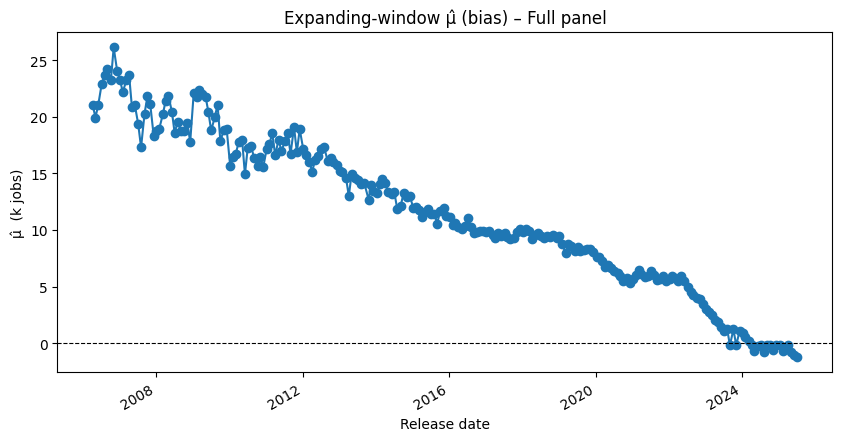

In [26]:
# -------------------------------------------------------------
# μ̂ diagnostics – Full panel • expanding-window Student-t
# -------------------------------------------------------------
import numpy as np, pandas as pd, scipy.stats as st, warnings
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
np.seterr(all="ignore")

MIN_TRAIN = 36                     # releases before first fit

# ---------- aggregate release-level series ----------
per_rel = (df_full
           .groupby("release_date")
           .agg(median_fc=("median_forecast", "median"),
                actual    =("actual",          "first"))
           .reset_index()
           .sort_values("release_date"))
per_rel["err"] = per_rel["median_fc"] - per_rel["actual"]
per_rel = per_rel.dropna(subset=["actual"]).reset_index(drop=True)

# ---------- expanding-window μ̂ estimates ----------
mu_rec = []
for i in tqdm(range(MIN_TRAIN, len(per_rel)), desc="Full panel"):
    _, mu_hat, _ = st.t.fit(per_rel.loc[:i-1, "err"].values)
    mu_rec.append({"date": per_rel.at[i, "release_date"], "mu_hat": mu_hat})

mu_df = pd.DataFrame(mu_rec)

# ---------- summary stats ----------
print("\nμ̂ summary statistics (k jobs):")
print(mu_df["mu_hat"].describe().round(2))

# ---------- time-series plot ----------
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(mu_df["date"], mu_df["mu_hat"], marker='o', color='tab:blue')
ax.axhline(0, color='black', lw=0.8, ls='--')
ax.set_title("Expanding-window μ̂ (bias) – Full panel")
ax.set_xlabel("Release date")
ax.set_ylabel("μ̂  (k jobs)")
fig.autofmt_xdate()
plt.show()


Rolling μ̂ | window=12:   0%|          | 0/256 [00:00<?, ?it/s]

Rolling μ̂ | window=36:   0%|          | 0/232 [00:00<?, ?it/s]


Rolling-window μ̂ summary (k jobs):
         count   mean    std      min     25%   50%    75%     max
window                                                            
12     256.000  1.360 31.420 -102.040 -10.290 1.900 15.930 124.310
36     232.000 -4.780 22.900  -59.200  -9.860 0.600 12.740  33.360


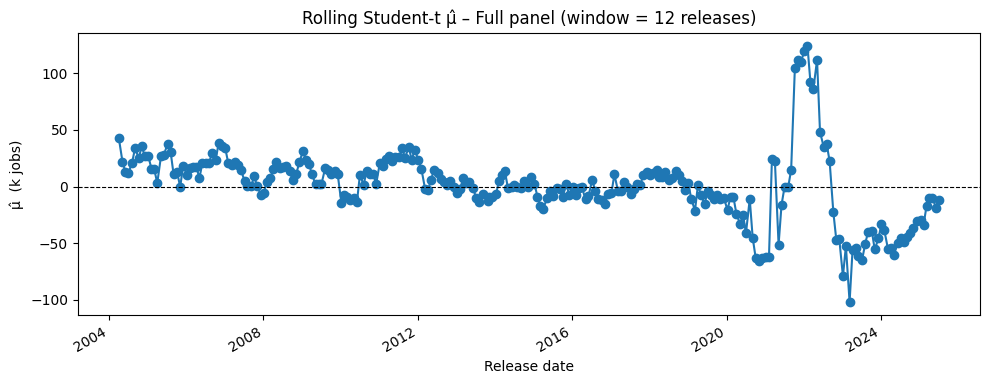

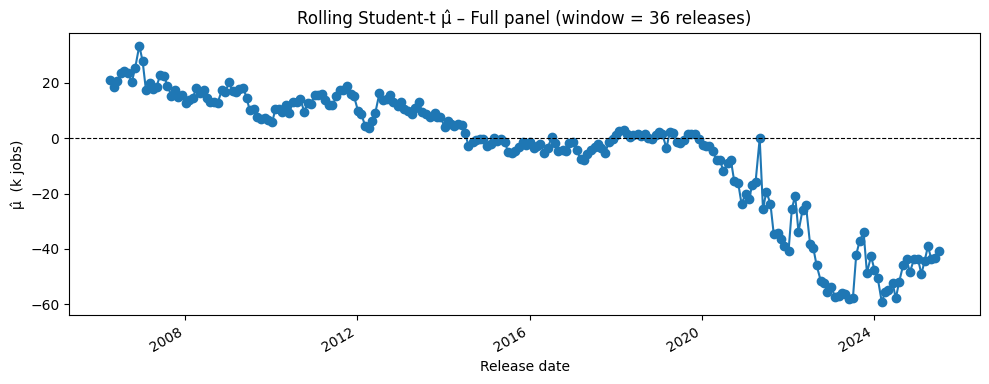

In [29]:
# -------------------------------------------------------------
# μ̂ diagnostics – Full panel • rolling Student-t
#           two independent figures (12- & 36-release windows)
# -------------------------------------------------------------
import numpy as np, pandas as pd, scipy.stats as st, warnings
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
np.seterr(all="ignore")

ROLL_WINS = [12, 36]               # ≈ 1-yr and 3-yr windows

# ---------- build release-level error series ----------
rel_df = (df_full
          .groupby("release_date")
          .agg(median_fc=("median_forecast", "median"),
               actual    =("actual",          "first"))
          .reset_index()
          .sort_values("release_date"))
rel_df["err"] = rel_df["median_fc"] - rel_df["actual"]
rel_df = rel_df.dropna(subset=["actual"]).reset_index(drop=True)

# ---------- rolling μ̂ and summary ----------
mu_records = []
for win in ROLL_WINS:
    for i in tqdm(range(win, len(rel_df)),
                  desc=f"Rolling μ̂ | window={win}", leave=False):
        errs = rel_df.loc[i-win:i-1, "err"].values
        _, mu_hat, _ = st.t.fit(errs)
        mu_records.append({"window": win,
                           "date"  : rel_df.at[i, "release_date"],
                           "mu_hat": mu_hat})

mu_df = pd.DataFrame(mu_records)

print("\nRolling-window μ̂ summary (k jobs):")
print(mu_df.groupby("window")["mu_hat"].describe().round(2))

# ---------- separate figures ----------
for win in ROLL_WINS:
    sub = mu_df[mu_df["window"] == win]
    plt.figure(figsize=(10, 4))
    plt.plot(sub["date"], sub["mu_hat"], marker='o', color='#1f77b4')
    plt.axhline(0, color='black', lw=0.8, ls='--')
    plt.title(f"Rolling Student-t μ̂ – Full panel (window = {win} releases)")
    plt.xlabel("Release date")
    plt.ylabel("μ̂  (k jobs)")
    plt.tight_layout()
    plt.gcf().autofmt_xdate()
    plt.show()


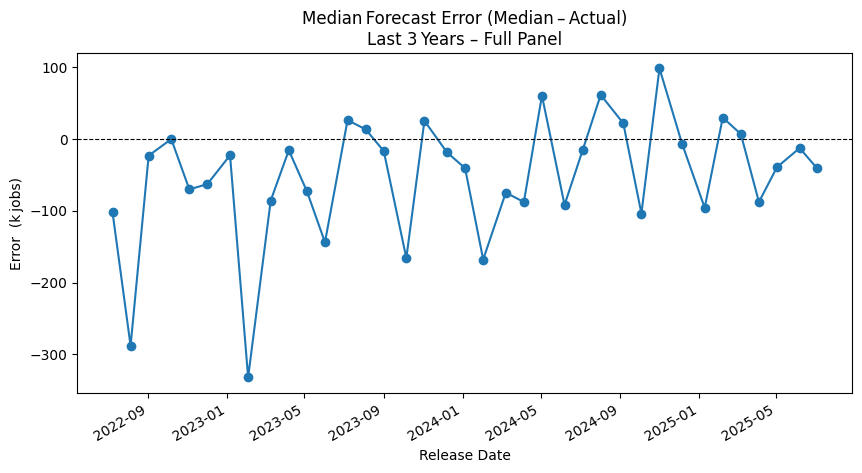

In [44]:
# let's visualize the recent prediction errors (consensus(median) - actual)

# 1. Compute the error series
per_rel = (df_full.groupby("release_date")
                     .agg(median_fc=("median_forecast", "median"),
                          actual=("actual", "first"))
                     .reset_index()
                     .sort_values("release_date"))

per_rel["error"] = per_rel["median_fc"] - per_rel["actual"]

# 2. Filter to the last 3 years
latest_date = per_rel["release_date"].max()
cutoff_date = latest_date - pd.DateOffset(years=3)
last3y = per_rel[per_rel["release_date"] >= cutoff_date]

# 3. Plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(last3y["release_date"], last3y["error"], marker="o")
ax.axhline(0, color="black", lw=0.8, ls="--")
ax.set_title("Median Forecast Error (Median – Actual)\nLast 3 Years – Full Panel")
ax.set_xlabel("Release Date")
ax.set_ylabel("Error  (k jobs)")
fig.autofmt_xdate()
plt.show()


**GARCH(1,1)**

In [ ]:
# -------------------------------------------------------------
#  GARCH(1,1)-t CIs  ― with / without crisis spread-adjustment
#  * comparable output to earlier Student-t experiments *
# -------------------------------------------------------------
import numpy as np, pandas as pd, scipy.stats as st, warnings
from collections import defaultdict
from tqdm.auto import tqdm
from arch.univariate import ConstantMean, GARCH, StudentsT

warnings.filterwarnings("ignore")
np.seterr(all="ignore")

# ---------------- configuration --------------------------------
MIN_TRAIN   = 36                    # releases before first band
ROLL_WIN    = None                  # expanding (set to int for rolling)
LEVELS      = [0.50,0.60,0.70,0.80,0.90,0.95,0.99]
SCALE       = 1000.0                # k-jobs ➜ hundreds
BETA_BASE   = 0.0
BETA_CRIS   = 0.80                  # elasticity from log-log regression
PCTL_THRES  = 0.95                  # top-5 % spread ⇒ “crisis”
PANEL       = df_full               # ← use COVID-filtered if preferred

# ---------------- data prep ------------------------------------
per_rel = (PANEL.groupby("release_date")
                   .agg(median_fc=("median_forecast","first"),
                        actual    =("actual","first"),
                        spread    =("forecast","std"))
                   .reset_index()
                   .sort_values("release_date"))
per_rel = per_rel[per_rel["actual"].notna()].reset_index(drop=True)
per_rel["err"] = per_rel["median_fc"] - per_rel["actual"]

# ---------------- helper ---------------------------------------
def garch_one_step(rescaled_errs):
    """Fit GARCH(1,1)-t to *rescaled* errors, return (nu, sigma_fc, mu_fc)."""
    cm = ConstantMean(rescaled_errs, rescale=False)
    cm.volatility  = GARCH(1, 1)
    cm.distribution = StudentsT()
    res = cm.fit(disp="off")
    fcast = res.forecast(horizon=1)
    mu_s  = fcast.mean.iloc[-1, 0]       # scaled
    h_s   = fcast.variance.iloc[-1, 0]
    sig   = np.sqrt(h_s) * SCALE
    mu    = mu_s * SCALE
    nu    = res.params["nu"]
    return nu, sig, mu

def half_width(level, nu, sigma):
    return st.t.ppf(1-(1-level)/2, df=nu) * sigma

# ---------------- run both specs --------------------------------
rows = []
for crisis_flag in (False, True):
    hits = defaultdict(int); totN = 0
    for i in tqdm(range(MIN_TRAIN, len(per_rel)), desc=f"GARCH | crisis={crisis_flag}"):
        # --- training window ------------------------------------
        start = 0 if ROLL_WIN is None else max(0, i-ROLL_WIN)
        errs  = per_rel.loc[start:i-1, "err"].values / SCALE
        nu, sig_fc, mu_fc = garch_one_step(errs)

        point   = per_rel.at[i, "median_fc"]
        actual  = per_rel.at[i, "actual"]
        spread_t= per_rel.at[i, "spread"]

        if crisis_flag:
            hist_sp = per_rel.loc[start:i-1, "spread"].values
            median_sp = np.median(hist_sp)
            pct_rank  = (hist_sp < spread_t).mean()
            beta      = BETA_BASE if pct_rank < PCTL_THRES else BETA_CRIS
            adj       = (spread_t / median_sp) ** beta
        else:
            adj = 1.0

        centre = point + mu_fc     # always μ-shift in GARCH spec

        for L in LEVELS:
            half = half_width(L, nu, sig_fc) * adj
            if centre - half <= actual <= centre + half:
                hits[L] += 1
        totN += 1

    # -------- store coverage + MA-gap ---------------------------
    ma_gap = np.mean([abs(hits[L]/totN - L) for L in LEVELS])
    spec_name = f"GARCH_{'CrisisAdj' if crisis_flag else 'NoAdj'}"
    for L in LEVELS:
        rows.append({"Spec": spec_name,
                     "Nominal": L,
                     "Empirical": hits[L]/totN,
                     "MA_gap": ma_gap})

# ---------------- tidy summary table ---------------------------
garch_tbl = (pd.DataFrame(rows)
               .pivot_table(index="Spec",
                            columns="Nominal",
                            values="Empirical")
               .assign(MA_gap=lambda d: d.index.map(
                   pd.Series({r["Spec"]: r["MA_gap"] for r in rows})))
               .sort_index())

pd.set_option("display.float_format", "{:.3f}".format)
print("\nGARCH(1,1)-t empirical coverage (and MA-gap):")
print(garch_tbl)


GARCH | crisis=False:   0%|          | 0/232 [00:00<?, ?it/s]

GARCH | crisis=True:   0%|          | 0/232 [00:00<?, ?it/s]


GARCH(1,1)-t empirical coverage (and MA-gap):
Nominal          0.500  0.600  0.700  0.800  0.900  0.950  0.990   MA_gap
Spec                                                                     
GARCH_CrisisAdj  0.552  0.647  0.746  0.797  0.901  0.948  0.987    0.022
GARCH_NoAdj      0.509  0.603  0.703  0.763  0.871  0.931  0.974    0.017


**Stratified GARCH(1,1)**

In [ ]:
# -------------------------------------------------------------
# 4-block test • GARCH(1,1)-t • 36-release window • NO crisis adj
# -------------------------------------------------------------

# ─── silence optimiser warnings ───────────────────────────────
warnings.filterwarnings("ignore", category=ConvergenceWarning)
np.seterr(all="ignore")

# ─── configuration ────────────────────────────────────────────
ROLL_WIN   = 36
MIN_TRAIN  = 36
LEVELS     = np.array([0.50,0.60,0.70,0.80,0.90,0.95,0.99])
SCALE      = 1_000.0                 # k-jobs → hundreds
PANELS     = {"Full": df_full, "COVID": df}   # choose panels here

# ─── helper functions ─────────────────────────────────────────
def garch_one_step(rescaled_errs: np.ndarray):
    """Return (ν, σₜ₊₁, μₜ₊₁) in original units for next step."""
    model = ConstantMean(rescaled_errs, rescale=False)
    model.volatility  = GARCH(1, 1)
    model.distribution = StudentsT()
    res   = model.fit(disp="off")
    fc    = res.forecast(horizon=1)
    mu_fc = fc.mean.iloc[-1, 0] * SCALE
    sig_fc= np.sqrt(fc.variance.iloc[-1, 0]) * SCALE
    nu_fc = res.params["nu"]
    return nu_fc, sig_fc, mu_fc

def t_half(level, nu, sigma):
    return st.t.ppf(1 - (1 - level)/2, df=nu) * sigma

# ─── main routine ─────────────────────────────────────────────
cov_rows, gap_rows = [], []

for pname, pdf in PANELS.items():

    per_rel = (pdf.groupby("release_date")
                     .agg(median_fc=("median_forecast", "first"),
                          actual    =("actual",          "first"))
                     .reset_index()
                     .sort_values("release_date"))
    per_rel = per_rel[per_rel["actual"].notna()].reset_index(drop=True)
    per_rel["err"] = per_rel["median_fc"] - per_rel["actual"]

    n_tot   = len(per_rel)
    blocks  = np.array_split(np.arange(n_tot), 4)

    for blk_no, idx in enumerate(blocks, 1):
        start_dt = per_rel.at[idx[0],  "release_date"].date()
        end_dt   = per_rel.at[idx[-1], "release_date"].date()

        hits = defaultdict(int); totN = 0

        for j in tqdm(idx, desc=f"{pname} | Block {blk_no}", leave=False):
            if j - idx[0] < ROLL_WIN:           # need 36 prior obs *inside* block
                continue

            errs = per_rel.loc[j-ROLL_WIN:j-1, "err"].values / SCALE
            nu_fc, sig_fc, mu_fc = garch_one_step(errs)

            centre = per_rel.at[j, "median_fc"] + mu_fc
            actual = per_rel.at[j, "actual"]

            for L in LEVELS:
                half = t_half(L, nu_fc, sig_fc)          # no extra multiplier
                if centre - half <= actual <= centre + half:
                    hits[L] += 1
            totN += 1

        if totN == 0:
            continue

        emp_vec = np.array([hits[L]/totN for L in LEVELS])

        # per-level coverage
        for L, emp in zip(LEVELS, emp_vec):
            cov_rows.append({"Panel": pname,
                             "Block": blk_no,
                             "Start": start_dt,
                             "End"  : end_dt,
                             "Nominal": L,
                             "Empirical": emp})

        # mean-absolute gap
        gap_rows.append({"Panel": pname,
                         "Block": blk_no,
                         "Start": start_dt,
                         "End"  : end_dt,
                         "AvgAbsGap": float(np.abs(emp_vec - LEVELS).mean())})

# ─── tidy output ───────────────────────────────────────────────
cov_tbl = (pd.DataFrame(cov_rows)
             .pivot_table(index=["Panel","Block","Start","End"],
                          columns="Nominal",
                          values="Empirical")
             .sort_index())

gap_tbl = (pd.DataFrame(gap_rows)
             .set_index(["Panel","Block","Start","End"])
             .sort_index())

pd.set_option("display.float_format", "{:.3f}".format)

print("\nGARCH(1,1)-t empirical coverage by block (no crisis adj):")
print(cov_tbl)

print("\nMean-absolute coverage gap (lower = better):")
print(gap_tbl)


Full | Block 1:   0%|          | 0/67 [00:00<?, ?it/s]

c:\Users\nwong\AppData\Local\Programs\Python\Python313\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\nwong\AppData\Local\Programs\Python\Python313\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Full | Block 2:   0%|          | 0/67 [00:00<?, ?it/s]

Full | Block 3:   0%|          | 0/67 [00:00<?, ?it/s]

Full | Block 4:   0%|          | 0/67 [00:00<?, ?it/s]

COVID | Block 1:   0%|          | 0/58 [00:00<?, ?it/s]

c:\Users\nwong\AppData\Local\Programs\Python\Python313\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\nwong\AppData\Local\Programs\Python\Python313\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


COVID | Block 2:   0%|          | 0/58 [00:00<?, ?it/s]

COVID | Block 3:   0%|          | 0/58 [00:00<?, ?it/s]

COVID | Block 4:   0%|          | 0/58 [00:00<?, ?it/s]


GARCH(1,1)-t empirical coverage by block (no crisis adj):
Nominal                            0.500  0.600  0.700  0.800  0.900  0.950  \
Panel Block Start      End                                                    
COVID 1     2003-04-04 2008-01-04  0.409  0.455  0.545  0.682  0.864  0.909   
      2     2008-02-01 2012-11-02  0.500  0.682  0.727  0.773  1.000  1.000   
      3     2012-12-07 2017-09-01  0.545  0.682  0.773  0.818  0.864  0.955   
      4     2017-10-06 2025-07-03  0.636  0.682  0.727  0.818  0.955  1.000   
Full  1     2003-04-04 2008-10-03  0.419  0.484  0.581  0.677  0.839  0.871   
      2     2008-11-07 2014-05-02  0.548  0.710  0.710  0.806  0.903  0.903   
      3     2014-06-06 2019-12-06  0.419  0.581  0.677  0.742  0.839  0.871   
      4     2020-01-10 2025-07-03  0.516  0.645  0.742  0.871  0.935  0.935   

Nominal                            0.990  
Panel Block Start      End                
COVID 1     2003-04-04 2008-01-04  0.955  
      2     2008-02-0

## Confidence intervals built around uncertainty in the cross-section

Test uncertainty quantification via cross-section modeling (whether this is even viable), test different fixed window lengths for optimal length (36)

In [22]:
# Buidling confidence intervals using uncertainty in the cross-section (in isolation), try rolling FIXED windows

# -------------------------------------------------------------
# XS-t (centre = μ̂)   &   TS-t  empirical coverage – both panels
# -------------------------------------------------------------
import numpy as np, pandas as pd, scipy.stats as st
from tqdm.auto import tqdm

LEVELS  = [0.50, 0.60, 0.70, 0.80, 0.90, 0.95]
TS_WINS = [12, 24, 36, 60, 120]          # months
MIN_XS  = 5                          # min forecasts in cross-section
PANELS  = {"COVID": df, "Full": df_full}

def in_band(center, sig, nu, level, actual):
    half = st.t.ppf(1 - (1-level)/2, df=nu) * sig
    return int(center - half <= actual <= center + half)

rows = []

for panel_name, panel in PANELS.items():

    # ---------------- XS-t (cross-section) ------------------
    xs_hits = {L: 0 for L in LEVELS};  xs_tot = 0

    for date, grp in tqdm(panel.groupby("release_date"), desc=f"{panel_name} XS"):
        sample = grp["forecast"].dropna().values
        act    = grp["actual"].iloc[0]
        if len(sample) < MIN_XS or np.isnan(act):
            continue
        nu, loc, sig = st.t.fit(sample)           # μ̂ = loc
        for L in LEVELS:
            xs_hits[L] += in_band(loc, sig, nu, L, act)
        xs_tot += 1

    for L in LEVELS:
        rows.append({"Method": f"{panel_name}-XS-t",
                     "Nominal": L,
                     "Empirical": xs_hits[L]/xs_tot if xs_tot else np.nan})

    # ---------------- TS-t (rolling errors) -----------------
    ts_hits = {w:{L:0 for L in LEVELS} for w in TS_WINS}
    ts_tot  = {w:0 for w in TS_WINS}

    panel_sorted = panel.sort_values("release_date")
    err_series = (panel_sorted.groupby("release_date")
                                .apply(lambda g: g["median_forecast"].iloc[0] - g["actual"].iloc[0])
                                .dropna())
    dates = err_series.index.to_list()

    for win in TS_WINS:
        for i in tqdm(range(win, len(dates)), desc=f"{panel_name} TS {win}m", leave=False):
            train_errs = err_series.iloc[i-win:i].values
            if train_errs.size < win:
                continue
            nu, mu, sig = st.t.fit(train_errs)

            cur_date   = dates[i]
            slc        = panel_sorted[panel_sorted["release_date"] == cur_date]
            point_med  = slc["median_forecast"].iloc[0]   # centre at median + μ̂
            actual_val = slc["actual"].iloc[0]
            if np.isnan(actual_val):
                continue

            center_ts  = point_med + mu                   # overall centre
            for L in LEVELS:
                ts_hits[win][L] += in_band(center_ts, sig, nu, L, actual_val)
            ts_tot[win] += 1

        for L in LEVELS:
            rows.append({"Method": f"{panel_name}-TS-t_{win}m",
                         "Nominal": L,
                         "Empirical": ts_hits[win][L]/ts_tot[win] if ts_tot[win] else np.nan})

# ---------------- coverage table -----------------
coverage_df = (pd.DataFrame(rows)
               .pivot(index="Method", columns="Nominal", values="Empirical")
               .sort_index())

print("\nEmpirical vs nominal coverage (XS-t centred at μ̂)")
print(coverage_df.to_string(float_format=lambda x: f"{x:0.3f}"))


COVID XS:   0%|          | 0/232 [00:00<?, ?it/s]

COVID TS 12m:   0%|          | 0/220 [00:00<?, ?it/s]

COVID TS 24m:   0%|          | 0/208 [00:00<?, ?it/s]

COVID TS 36m:   0%|          | 0/196 [00:00<?, ?it/s]

COVID TS 60m:   0%|          | 0/172 [00:00<?, ?it/s]

COVID TS 120m:   0%|          | 0/112 [00:00<?, ?it/s]

Full XS:   0%|          | 0/268 [00:00<?, ?it/s]

Full TS 12m:   0%|          | 0/256 [00:00<?, ?it/s]

Full TS 24m:   0%|          | 0/244 [00:00<?, ?it/s]

Full TS 36m:   0%|          | 0/232 [00:00<?, ?it/s]

Full TS 60m:   0%|          | 0/208 [00:00<?, ?it/s]

Full TS 120m:   0%|          | 0/148 [00:00<?, ?it/s]


Empirical vs nominal coverage (XS-t centred at μ̂)
Nominal          0.500  0.600  0.700  0.800  0.900  0.950
Method                                                   
COVID-TS-t_120m  0.500  0.634  0.688  0.741  0.884  0.920
COVID-TS-t_12m   0.441  0.527  0.632  0.741  0.855  0.914
COVID-TS-t_24m   0.471  0.562  0.654  0.740  0.885  0.933
COVID-TS-t_36m   0.485  0.571  0.653  0.740  0.857  0.939
COVID-TS-t_60m   0.471  0.576  0.674  0.733  0.884  0.919
COVID-XS-t       0.224  0.276  0.345  0.418  0.487  0.591
Full-TS-t_120m   0.419  0.527  0.622  0.723  0.811  0.919
Full-TS-t_12m    0.441  0.527  0.637  0.746  0.855  0.914
Full-TS-t_24m    0.451  0.549  0.660  0.750  0.893  0.934
Full-TS-t_36m    0.453  0.556  0.642  0.767  0.875  0.944
Full-TS-t_60m    0.433  0.529  0.668  0.731  0.885  0.928
Full-XS-t        0.228  0.287  0.354  0.422  0.496  0.601


**Quick sanity check - inspect results for most recent release**

In [5]:
# warnings.filterwarnings("ignore")
# np.seterr(all="ignore")

# # ------------- parameters ------------------------------------------------
# TARGET_DATE = pd.Timestamp("2025-07-03")
# LEVELS      = [0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
# ROLL_WIN    = 36                          # 36 realised releases ≈ 3 years

# # -------------------------------------------------------------------------
# # 1.  Cross-section Student-t (forecasts themselves)
# # -------------------------------------------------------------------------
# xs = df_full.loc[df_full["release_date"] == TARGET_DATE, "forecast"].dropna()
# if xs.empty:
#     raise ValueError(f"No forecasts found for {TARGET_DATE.date()}")

# nu_xs, loc_xs, sig_xs = st.t.fit(xs.values)

# print(f"\nCross-section Student-t fit for {TARGET_DATE.date()}")
# print(f"  ν (df)   = {nu_xs:6.2f}")
# print(f"  μ (loc)  = {loc_xs:6.2f}  k jobs")
# print(f"  σ (scale)= {sig_xs:6.2f}  k jobs")

# print("\nPrediction bands (centred at μ̂, cross-section):")
# for L in LEVELS:
#     half = st.t.ppf(1 - (1 - L) / 2, df=nu_xs) * sig_xs
#     lo, hi = loc_xs - half, loc_xs + half
#     print(f"  {int(L*100):>2}% CI : [ {lo:7.1f} , {hi:7.1f} ]  k jobs")

# # -------------------------------------------------------------------------
# # 2.  Time-series Student-t (rolling 36-release error window)
# # -------------------------------------------------------------------------
# # build one realised error per release (median – actual)
# err_ser = (df_full.sort_values("release_date")
#                      .groupby("release_date")
#                      .apply(lambda g: g["median_forecast"].iloc[0]
#                                      - g["actual"].iloc[0])
#                      .dropna())             # drop unreleased months (actual = NaN)

# # keep only history strictly BEFORE the target date
# hist_errs = err_ser[err_ser.index < TARGET_DATE].tail(ROLL_WIN)

# if len(hist_errs) < ROLL_WIN:
#     raise ValueError(f"Need {ROLL_WIN} realised errors before "
#                      f"{TARGET_DATE.date()}, found only {len(hist_errs)}.")

# nu_ts, mu_ts, sig_ts = st.t.fit(hist_errs.values)

# point_median = (df_full.loc[df_full["release_date"] == TARGET_DATE,
#                             "median_forecast"]
#                 .dropna()
#                 .iloc[0])

# center_ts = point_median + mu_ts   # centre of TS band

# print(f"\nTime-series Student-t (last {ROLL_WIN} realised errors)")
# print(f"  ν (df)   = {nu_ts:6.2f}")
# print(f"  μ̂_TS     = {mu_ts:6.2f}  k jobs   (added to median forecast)")
# print(f"  σ̂_TS     = {sig_ts:6.2f}  k jobs")
# print(f"  Median forecast on {TARGET_DATE.date()} : {point_median:.1f} k jobs")
# print(f"  Band centre (median + μ̂_TS)            : {center_ts:.1f} k jobs")

# print("\nPrediction bands (time-series Student-t):")
# for L in LEVELS:
#     half = st.t.ppf(1 - (1 - L) / 2, df=nu_ts) * sig_ts
#     lo, hi = center_ts - half, center_ts + half
#     print(f"  {int(L*100):>2}% CI : [ {lo:7.1f} , {hi:7.1f} ]  k jobs")
    

# # -------------------------------------------------------------------------
# # 3.  Time–series GARCH-t (expanding window up to TARGET_DATE-1)
# # -------------------------------------------------------------------------

# SCALE_G = 1_000.0          # match earlier scaling (k-jobs → 100s)

# # build realised error series (median – actual), strictly before target
# err_series = (df_full.sort_values("release_date")
#                        .groupby("release_date")
#                        .apply(lambda g: g["median_forecast"].iloc[0]
#                                      - g["actual"].iloc[0])
#                        .dropna())
# err_hist  = err_series[err_series.index < TARGET_DATE]

# if len(err_hist) < MIN_TRAIN:          # MIN_TRAIN = 36 you defined earlier
#     raise ValueError("Need at least 36 realised releases before target date")

# # rescale then fit expanding-window GARCH-t
# train_e   = err_hist / SCALE_G
# cm        = ConstantMean(train_e, rescale=False)
# cm.volatility  = GARCH(1, 1)
# cm.distribution = StudentsT()
# garch_res = cm.fit(disp="off")

# # one-step forecast on the *rescaled* scale
# fc        = garch_res.forecast(horizon=1)
# mu_g_s    = fc.mean.iloc[-1, 0]          # scaled mean (≈0)
# h_next_s  = fc.variance.iloc[-1, 0]

# # back-scale to k-jobs
# sigma_g   = np.sqrt(h_next_s) * SCALE_G
# mu_g      = mu_g_s * SCALE_G
# nu_g      = garch_res.params["nu"]

# # centre is (median forecast + mu_g)
# band_ctr  = point_median + mu_g

# print(f"\nGARCH-t one-step forecast (expanding window to {TARGET_DATE.date()-pd.Timedelta(days=1)})")
# print(f"  ν  (df)  = {nu_g:6.2f}")
# print(f"  μ̂_G      = {mu_g:6.2f}  k jobs (added to median)")
# print(f"  σ̂_G      = {sigma_g:6.2f}  k jobs")
# print(f"  Band centre (median + μ̂_G) : {band_ctr:.1f} k jobs")

# print("\nPrediction bands (GARCH-t):")
# for L in LEVELS:
#     q    = st.t.ppf(1 - (1 - L)/2, df=nu_g)
#     half = q * sigma_g
#     lo, hi = band_ctr - half, band_ctr + half
#     print(f"  {int(L*100):>2}% CI : [ {lo:7.1f} , {hi:7.1f} ]  k jobs")


## Distributional forecasting

We deploy 3 distributional forecasting methods to quantify forecast uncertainty
1. Gaussian Mixture Models
2. Bayesian Model Averaging
3. Kalman filter